In [1]:
%matplotlib inline
import numpy as np
import jax.numpy as jnp
from jax.ops import index, index_update
from jax.config import config
from tqdm.notebook import trange

from os.path import join
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter, freqz

sns.set_theme('talk', 'white')
plt.rcParams["figure.figsize"] = (8,8)

config.update("jax_enable_x64", True)

data_folder = join(join('..', 'data'), 'congedo')

In [2]:
def make_distanceMatrix(points, distance):
    Npoints = len(points)
    distmatrix = np.zeros((Npoints, Npoints))
    for ii,pi in enumerate(points):
        for jj,pj in enumerate(points):
            distmatrix[ii,jj] = distance(pi,pj)            
            
    return distmatrix

def renormalize_kernel(kernel, alpha):    
    q = np.power(np.dot(kernel, np.ones(len(kernel))), alpha)
    K = np.divide(kernel, np.outer(q,q))    
    return K        

def make_kernelMatrix(distmatrix, eps):
    kernel = np.exp(-distmatrix**2/eps)            
    return kernel

def make_transitionMatrix(kernel):    
    d = np.sqrt(np.dot(kernel, np.ones(len(kernel))))
    P = np.divide(kernel, np.outer(d, d))    
    return P

def get_diffusionEmbedding(points=[], distance=[], distmatrix=None, alpha=1.0, tdiff=0, eps=None):
    
    if distmatrix is None:
        d = make_distanceMatrix(points, distance)          
    else:
        d = distmatrix

    if eps is None:
        # using heuristic from the R package for diffusion maps
        eps = 2*np.median(d)**2      
            
    K = make_kernelMatrix(distmatrix=d, eps=eps)
    Kr = renormalize_kernel(K, alpha=alpha)            
    P = make_transitionMatrix(Kr)
    u,s,v = np.linalg.svd(P)    
    
    phi = np.copy(u)
    for i in range(len(u)):
        phi[:,i] = (s[i]**tdiff)*np.divide(u[:,i], u[:,0])
    
    return phi, s


In [3]:
# Functions
isqrt = lambda x: 1. / jnp.sqrt(x)
funs = {'sqrt': jnp.sqrt,
        'isqrt': isqrt,
        'log': jnp.log,
        'exp': jnp.exp}

def norm_frob_squared(X):
    return jnp.einsum('...ji,...ji', X, X)

def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

def transform_mat(X, func='sqrt'):
    u, v = jnp.linalg.eigh(X)
    return jnp.einsum('...ij,...j,...kj', v, funs[func](u), v)

def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = jnp.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

def costfunc(X, Y):
    return jnp.sum(dist_riem_squared(X, Y))

def costfuncproc(X, Y):
    return jnp.sum(dist_frob_squared(X, Y))

def rotate(X, Omega):
    return np.einsum('...ij,...jk,...lk', Omega, X, Omega)

def optimal_rotation(X, M):
    _, g_m = np.linalg.eigh(M)
    _, g_x = np.linalg.eigh(X)
    return np.einsum('...ij,...kj', g_m, g_x)

def optimal_reference_eigval(X):
    u = np.linalg.eigvalsh(X)
    return np.exp(np.sum(np.log(u), axis=0) / X.shape[0])

def optimal_reference_eigvec(X):
    _, vs = np.linalg.eigh(Sigmas)
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    return np.einsum('...ij,...jk', U, V)

def optimal_reference(X):
    u, vs = jnp.linalg.eigh(X)
    eigval = jnp.exp(jnp.sum(jnp.log(u), axis=0) / X.shape[0])
    U, _, V = jnp.linalg.svd(jnp.sum(vs, axis=0))
    eigvec = jnp.einsum('...ij,...jk', U, V)
    return jnp.einsum('...ij,...j,...kj', eigvec, eigval, eigvec)

def corr_from_cov(cov):
    diag = np.sqrt(np.diag(cov))
    return np.einsum('...i,...ij,...j->...ij', 1./diag, cov, 1./diag)


In [4]:
def butter_bandpass(cutoffs=(8, 35), fs=512, order=6):
    nyq = 0.5 * fs
    normal_cutoffs = np.array(cutoffs) / nyq
    b, a = butter(order, normal_cutoffs, btype='bandpass', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoffs=(8, 35), fs=512, order=6):
    b, a = butter_bandpass(cutoffs, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 512       # sample rate, Hz
cutoffs = np.array([8, 35])  # desired cutoff frequency of the filter, Hz


In [5]:
def extract_covs(subject):
    head = pd.read_csv(join(data_folder, 'header.csv')).columns
    data = pd.read_csv(join(data_folder, "subject_{:02}.csv".format(subject)),
                            header=None,
                            names=head).set_index('Time')

    S = data.iloc[:, :16].to_numpy()
    stim = (1 * data.EyesClosed + 2 * data.EyesOpened).to_numpy()

    chnames = ['Fp1',
               'Fp2',
               'FC5',
               'Fz',
               'FC6',
               'T7',
               'Cz',
               'T8',
               'P7',
               'P3',
               'Pz',
               'P4',
               'P8',
               'O1',
               'Oz',
               'O2',
               'stim'
              ]
    chtypes = ['eeg'] * 16 + ['stim']

    X = np.concatenate([S, np.expand_dims(stim, -1)], axis=1).T
    info = mne.create_info(ch_names=chnames, sfreq=512, ch_types=chtypes, verbose=False)
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(data=X, info=info, verbose=False)
    
    fmin = 3
    fmax = 40
    raw.filter(fmin, fmax, verbose=False)
    raw.resample(sfreq=128, verbose=False)

    events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
    event_id = {'closed':1, 'open':2}
    epochs = mne.Epochs(raw, events, event_id,
                        tmin=2.0, tmax=8.0,
                        baseline=(None, None), 
                        verbose=False, preload=True)
    
    epochs.pick_types(eeg=True)

    cova_open = mne.compute_covariance(epochs['open'],
                                   #method='ledoit_wolf',
                                   scalings={'eeg':1e6},
                                   verbose=False,
                                  )
    cova_clos = mne.compute_covariance(epochs['closed'],
                                   #method='ledoit_wolf',
                                   scalings={'eeg':1e6},
                                   verbose=False,
                                  )

    #X = epochs.get_data()
    #X = (X - np.expand_dims(X.mean(axis=-1), -1)) / np.expand_dims(X.std(axis=-1), -1)
    #covs = np.einsum('...ij,...kj', X, X) / X.shape[-1]
    
    covs = np.concatenate([np.expand_dims(cova_open['data'] / cova_open.nfree, 0),
                           np.expand_dims(cova_clos['data'] / cova_clos.nfree, 0)], axis=0)
    
    y = ['open', 'closed']

    return covs, y


def extract_covs_brute(subject):
    head = pd.read_csv(join(data_folder, 'header.csv')).columns
    data = pd.read_csv(join(data_folder, "subject_{:02}.csv".format(subject)),
                            header=None,
                            names=head).set_index('Time')

    closed = np.zeros(shape=len(data), dtype=bool)
    for i, x in enumerate(data.itertuples()):
        if x.EyesClosed:
            closed[i] = True
        elif x.EyesOpened:
            closed[i] = False
        elif closed[i-1]:
            closed[i] = True
    
    data = data.loc[:, :"O2"].apply(lambda x: (x - x.mean()) / x.std())
    data = data.apply(lambda x: butter_bandpass_filter(x))
    
    cl = data.loc[closed].to_numpy()
    op = data.loc[~closed].to_numpy()
    
    n_cl = cl.shape[0]; n_op = op.shape[0]
    
    covs = np.concatenate([np.expand_dims(op.T @ op / n_op, 0), 
                           np.expand_dims(cl.T @ cl / n_cl, 0)], axis=0)
    
    y = ['open', 'closed']
    lengths = [n_op, n_cl]
    return covs, y, lengths

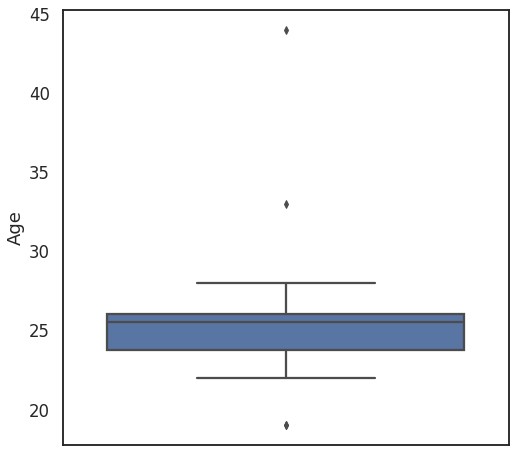

In [6]:
#### Demographics:
demographics = pd.read_csv(join(data_folder, 'demographic.csv'),
                           header=None,
                           names=pd.read_csv(join(data_folder, 'demographic_header.csv')).columns
                          )
demographics.set_index('Subject', inplace=True)
demographics['IsMan'] = demographics.IsMan.astype(bool)
demographics['Gender'] = demographics.IsMan.apply(lambda x: 'Man' if x else 'Woman')

sns.boxplot(data=demographics, y='Age')
plt.show()

In [7]:
Sigmas = []
labels = []
ages = []
subjects = []
genders = []
lengths = []

import csv
cov_folder = join(join('..', 'data'), 'covariances')
filename = lambda x, y: join(cov_folder, 'subject_{:02}_{}.csv'.format(x, y))

for i in trange(20):
    subject = i + 1
    #print('Reading subject {:02}...'.format(subject))
    c, y, lens = extract_covs_brute(subject)
    Sigmas.append(c)
    labels += list(y)
    ages += [int(demographics.loc[subject, 'Age'])] * len(y)
    genders += ['Male' if demographics.loc[subject, 'IsMan'] else 'Female'] * len(y)
    subjects += [subject] * len(y)
    lengths += list(lens)
    for e, eyes in enumerate(['open', 'closed']):
        with open(filename(subject, eyes), 'w', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            for r in c[e]:
                writer.writerow(r)
    
Sigmas = np.concatenate(Sigmas, axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

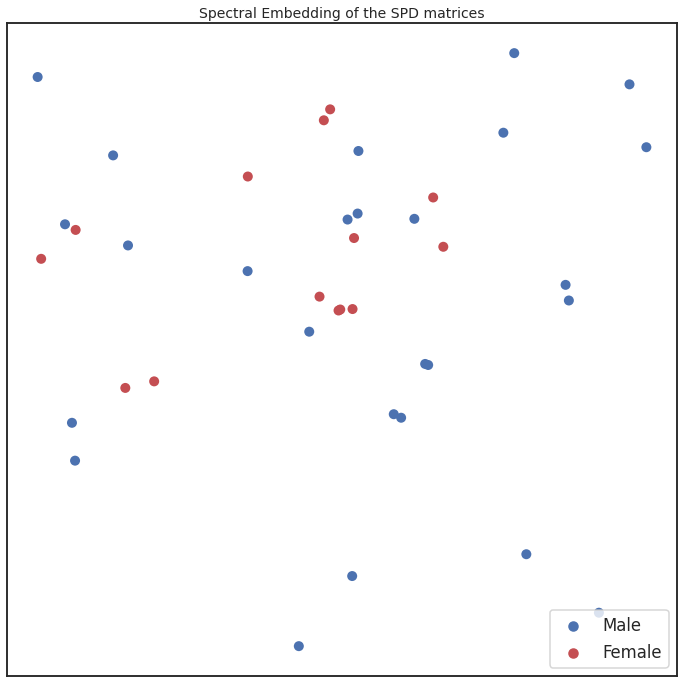

In [8]:
uorg, l = get_diffusionEmbedding(points=Sigmas, distance=lambda x, y: np.sqrt(dist_riem_squared(x, y)))

# plot the scatter plot for the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(12,12))

colors = {'Male':'b', 'Female':'r'}
for i in range(Sigmas.shape[0]):
    ax.scatter(uorg[i, 1], uorg[i, 2], s=100, facecolor=colors[genders[i]], edgecolor='none')
ax.set_title('Spectral Embedding of the SPD matrices', fontsize=14)   
ax.set_xticks([])
ax.set_yticks([])
ax.scatter([], [], facecolor=colors['Male'], label='Male')
ax.scatter([], [], facecolor=colors['Female'], label='Female')
ax.legend(loc='lower right');

In [9]:
ref_eigvals = optimal_reference_eigval(Sigmas)
ref_eigvect = optimal_reference_eigvec(Sigmas)
reference = np.einsum('...ij,...j,...kj', ref_eigvect, ref_eigvals, ref_eigvect)

Omegas = optimal_rotation(Sigmas, reference)

Sigmas_rotated = rotate(Sigmas, Omegas)

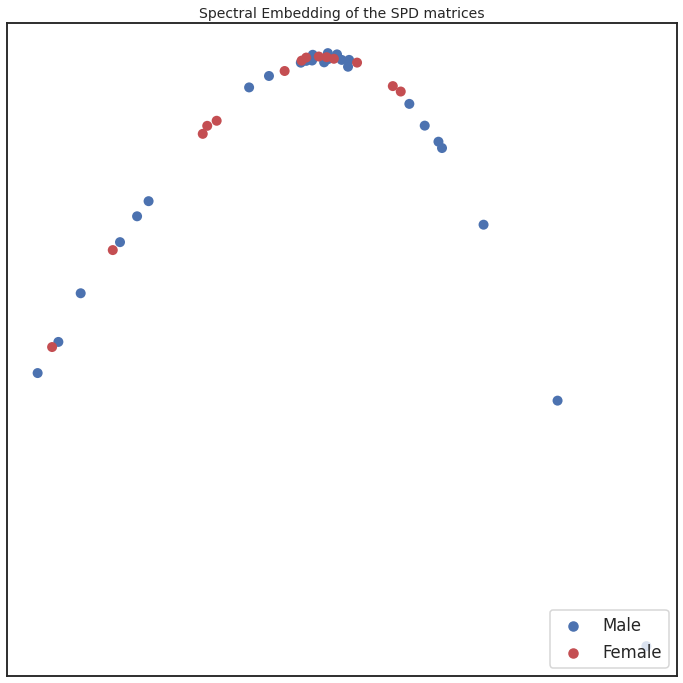

In [10]:
uorg, l = get_diffusionEmbedding(points=Sigmas_rotated, distance=lambda x, y: np.sqrt(dist_riem_squared(x, y)))

# plot the scatter plot for the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(12,12))

colors = {'Male':'b', 'Female':'r'}
for i in range(Sigmas_rotated.shape[0]):
    ax.scatter(uorg[i, 1], uorg[i, 2], s=100, facecolor=colors[genders[i]], edgecolor='none')
ax.set_title('Spectral Embedding of the SPD matrices', fontsize=14)   
ax.set_xticks([])
ax.set_yticks([])
ax.scatter([], [], facecolor=colors['Male'], label='Male')
ax.scatter([], [], facecolor=colors['Female'], label='Female')
ax.legend(loc='lower right');

In [11]:
#s_max_or, s_min_or = np.max(Sigmas), np.min(Sigmas)
#s_max_ro, s_min_ro = np.max(Sigmas_rotated), np.min(Sigmas_rotated)
s_max, s_min = 1., -1.

colmap = sns.diverging_palette(20, 220, n=200)

mask = np.zeros(shape=Sigmas.shape[1:])
mask[np.triu_indices_from(mask)] = True

base = 6
figsize = (base * 2, base * 20)

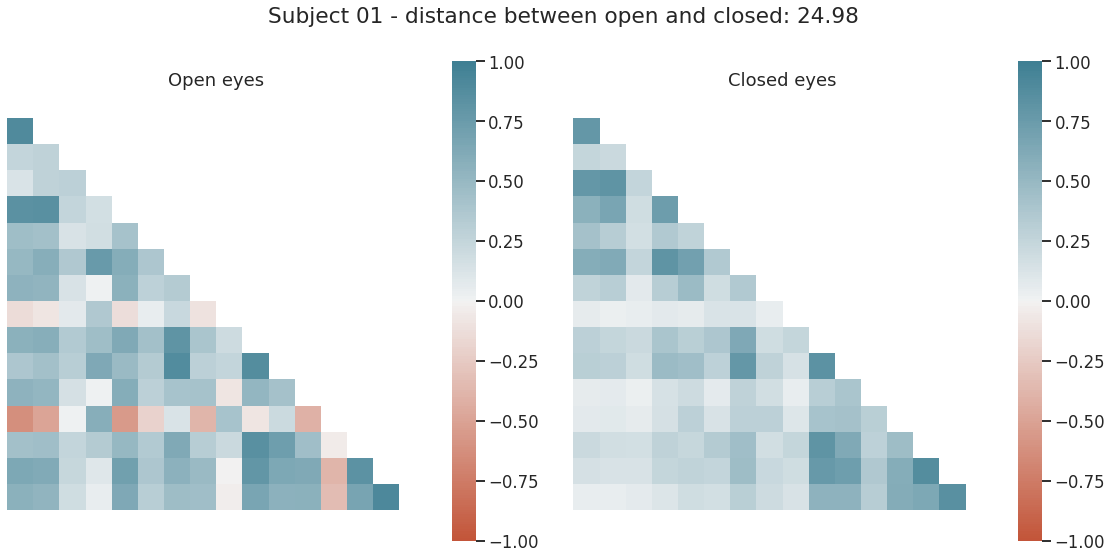

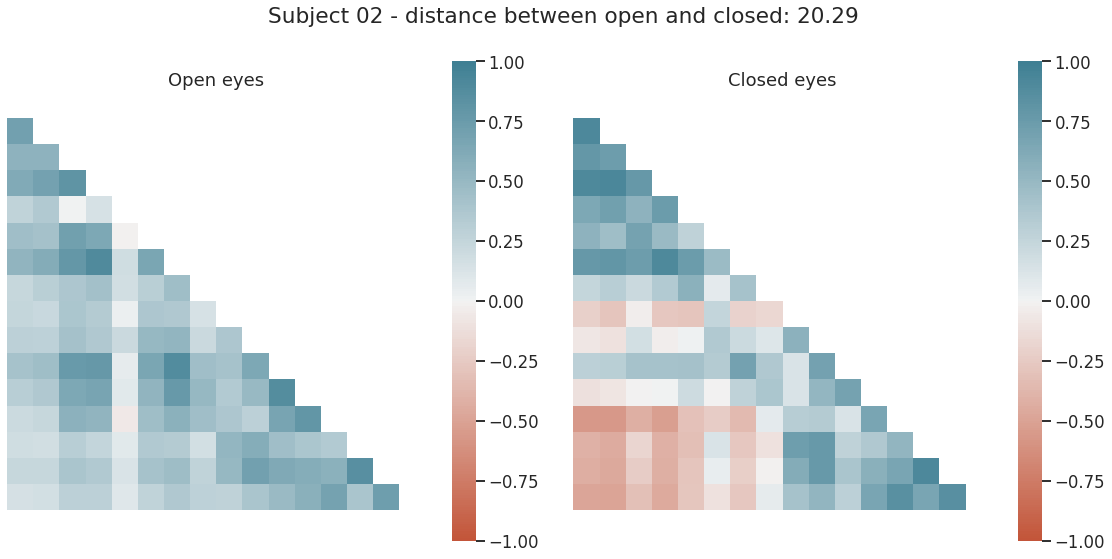

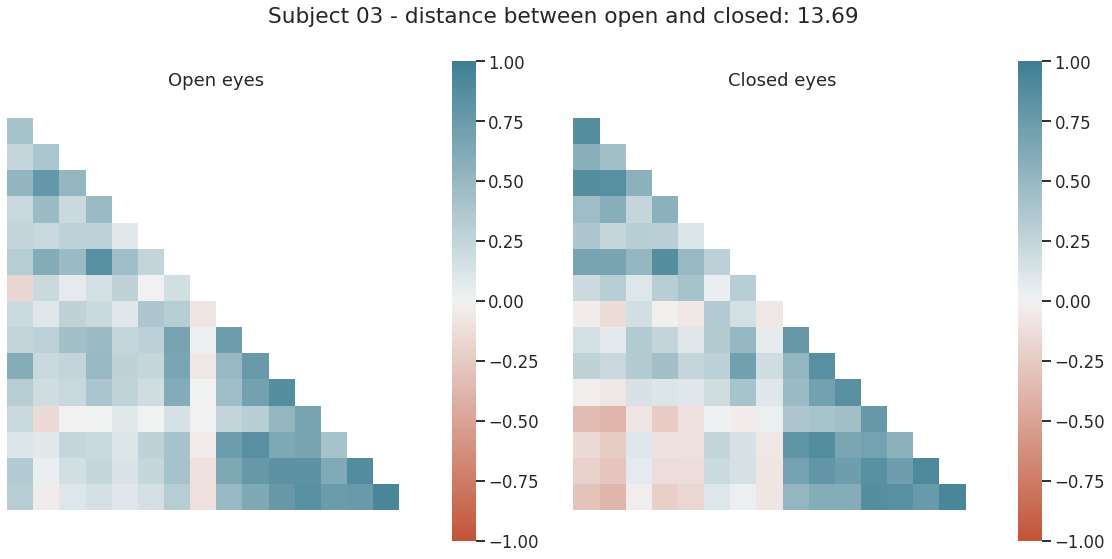

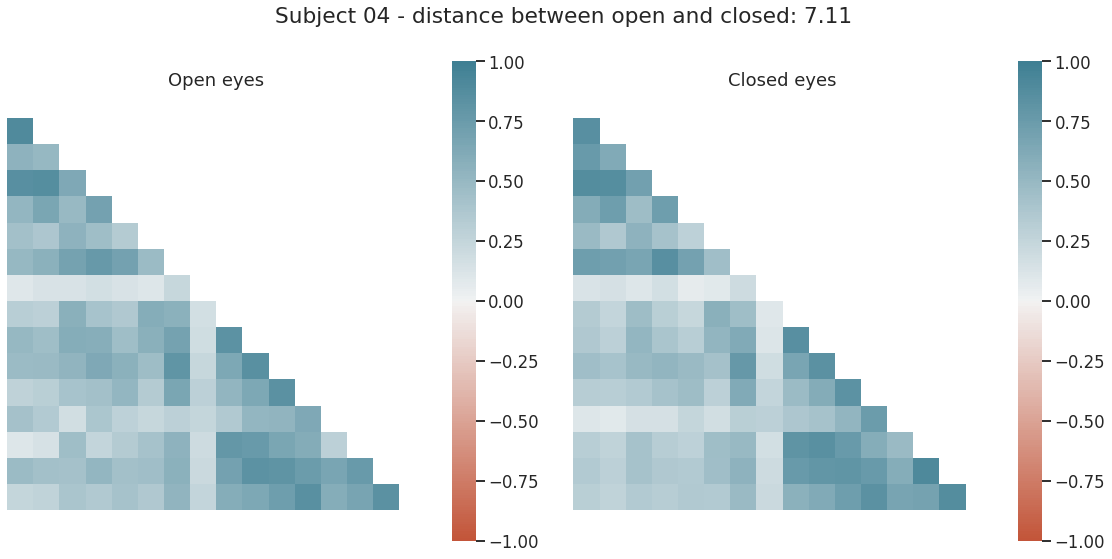

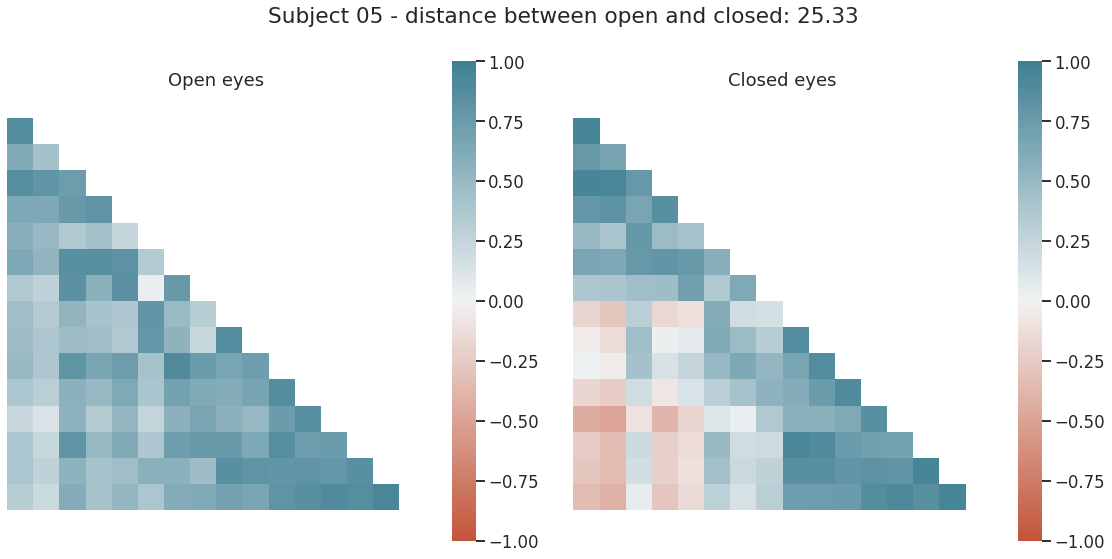

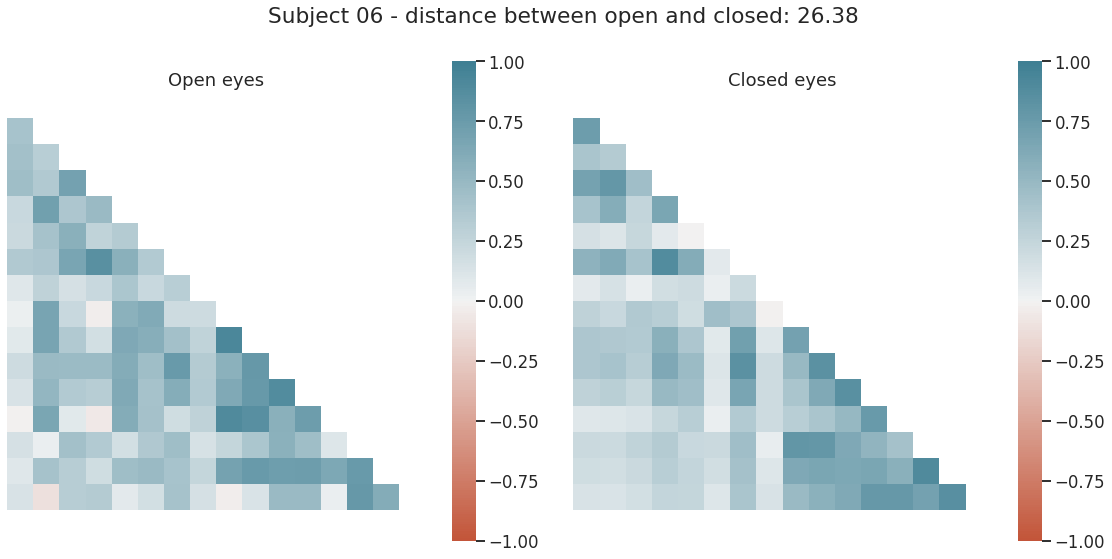

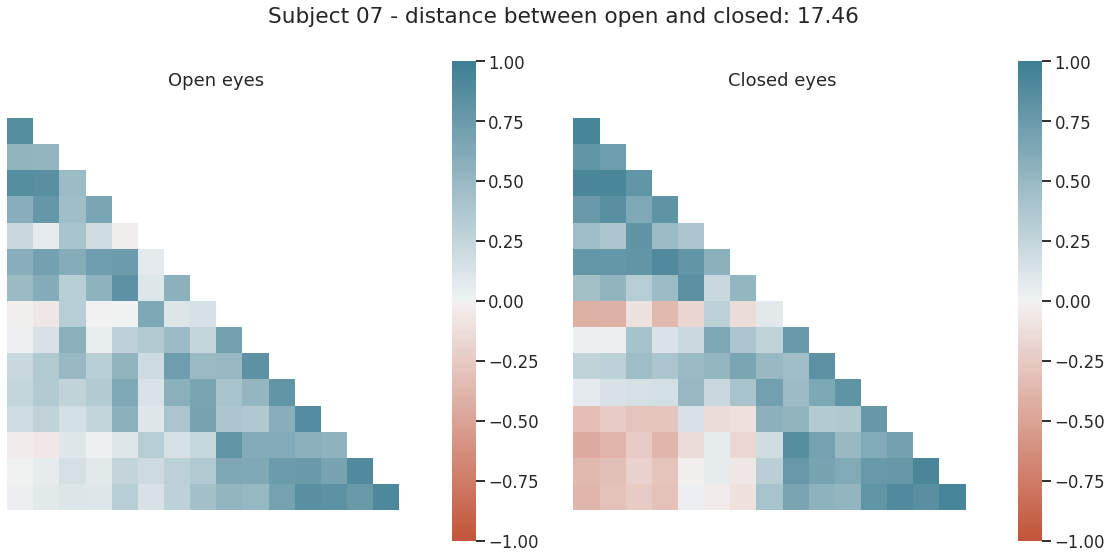

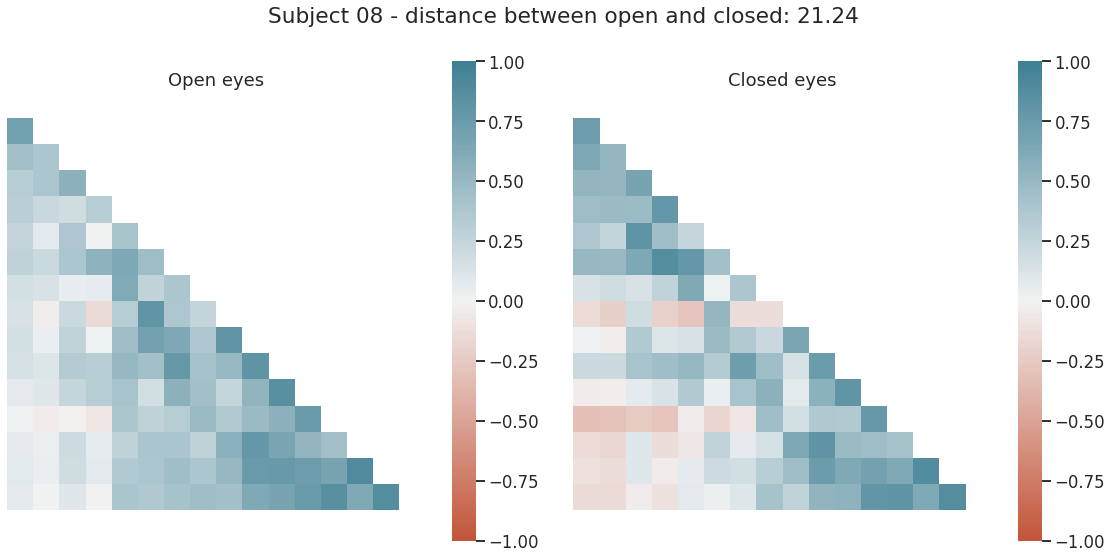

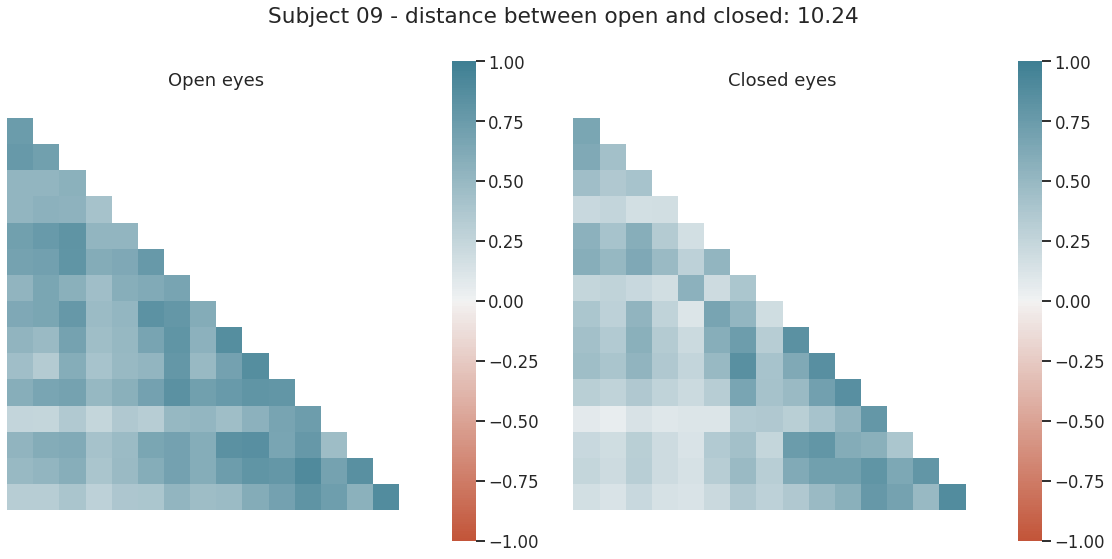

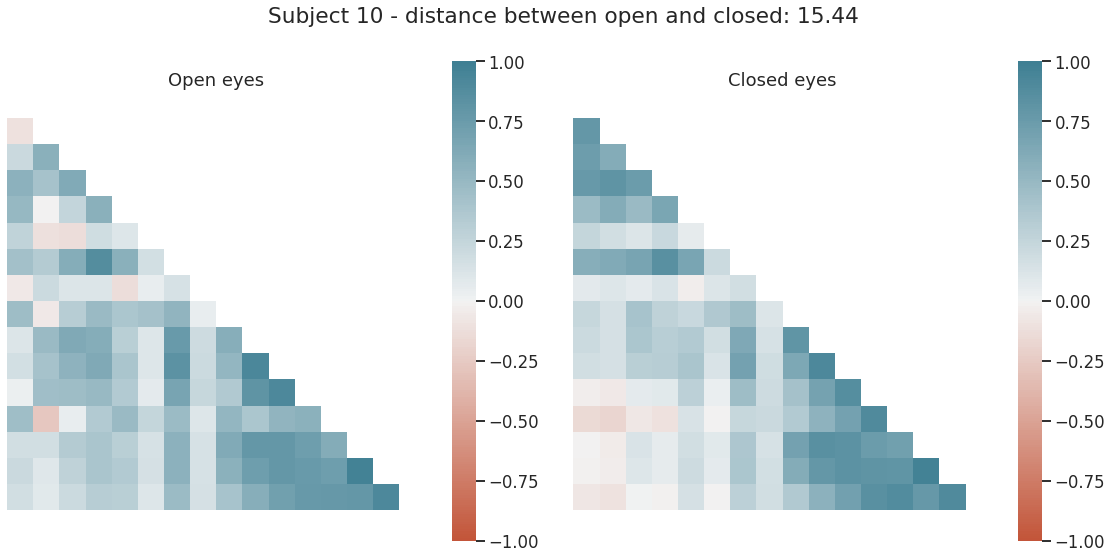

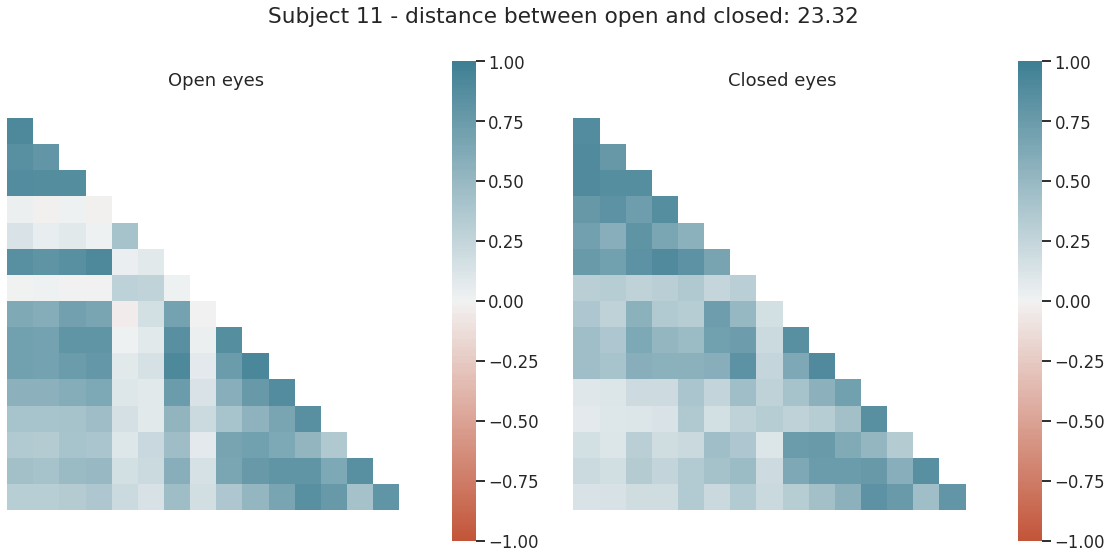

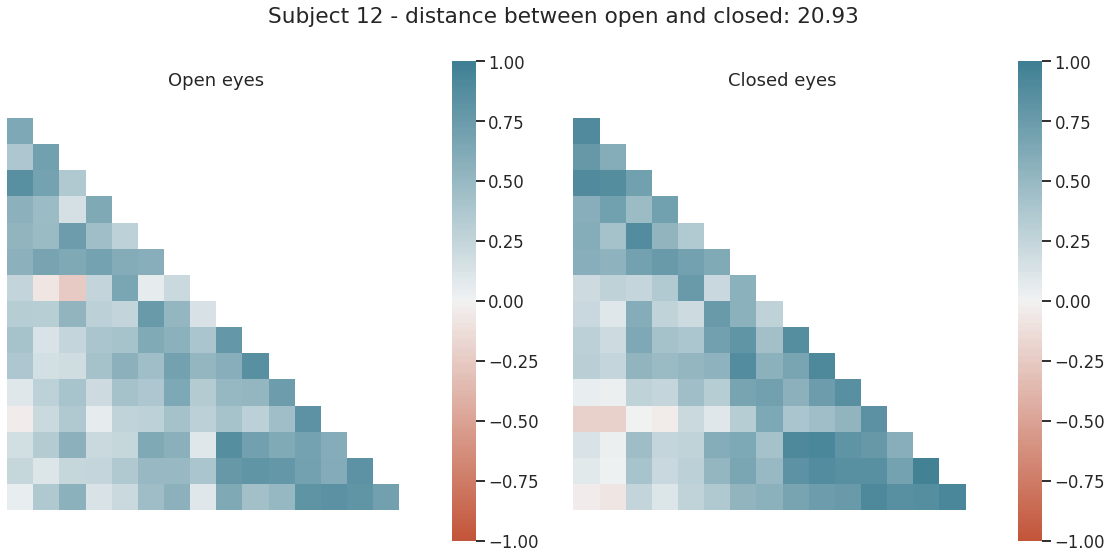

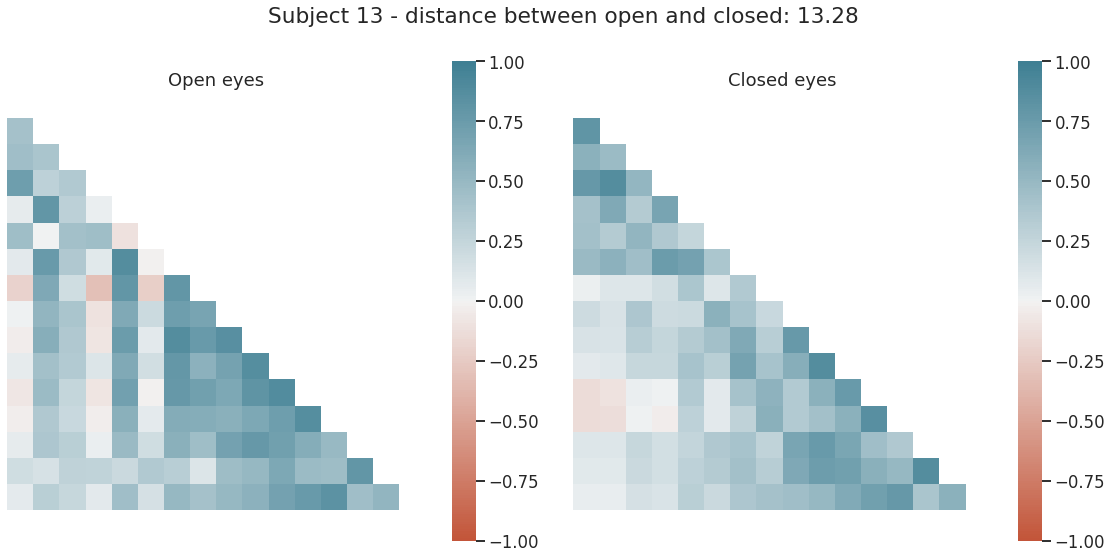

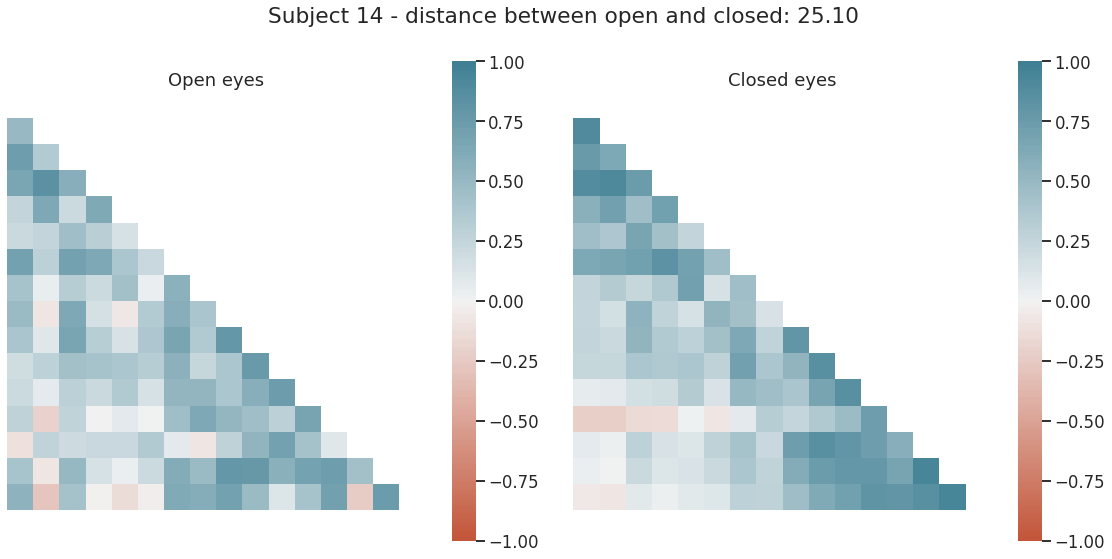

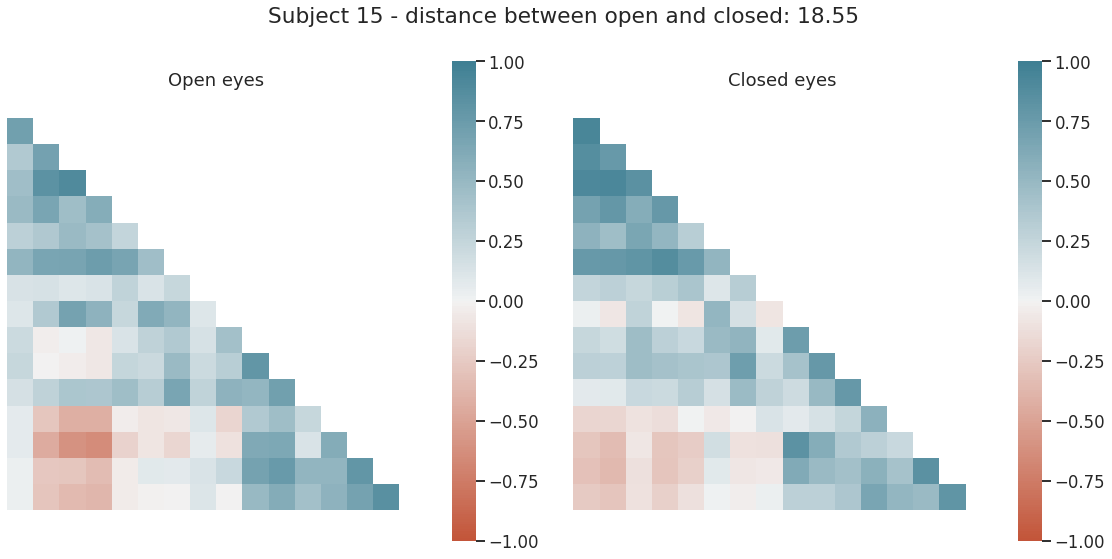

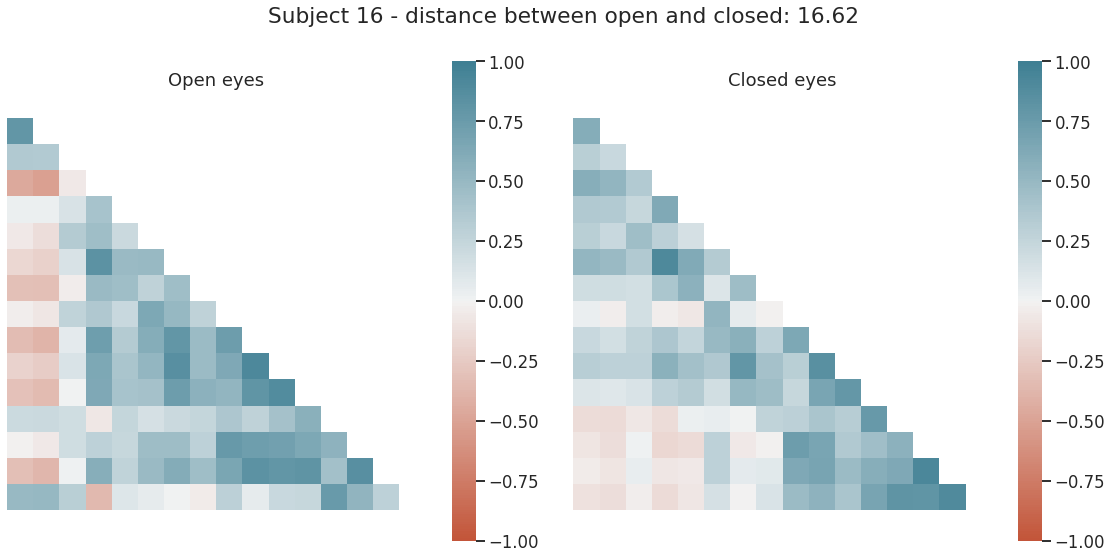

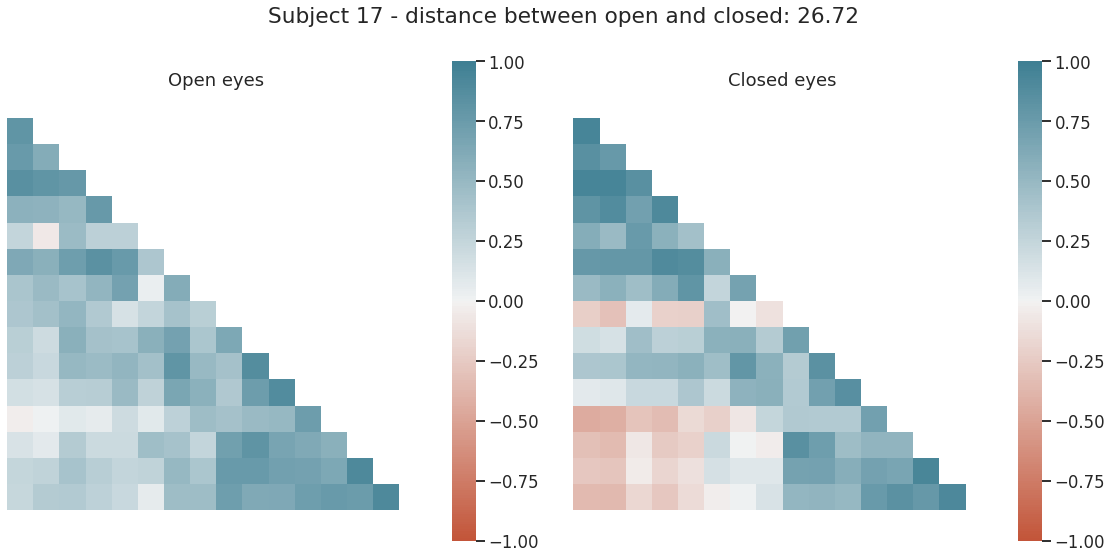

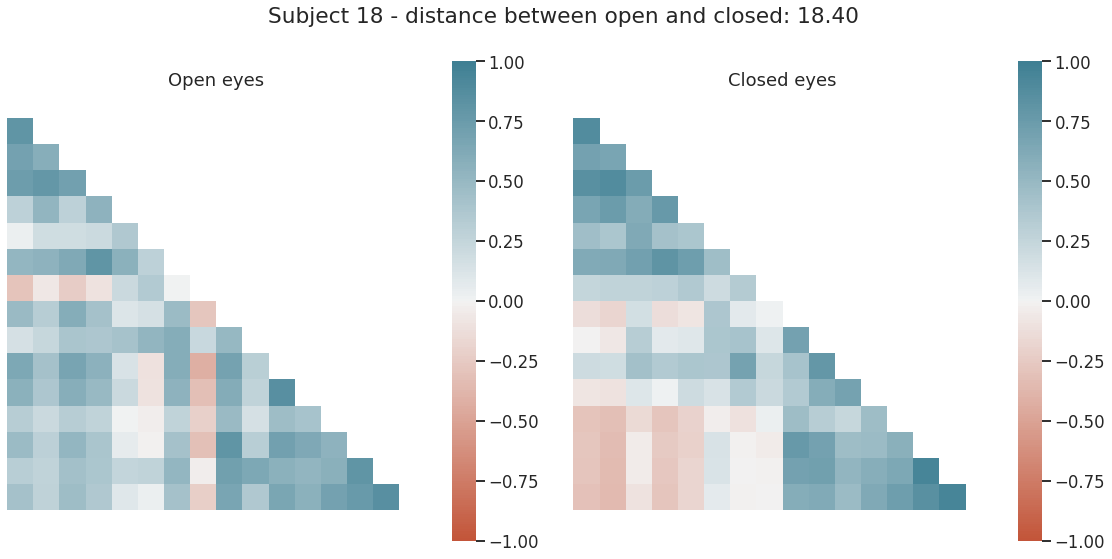

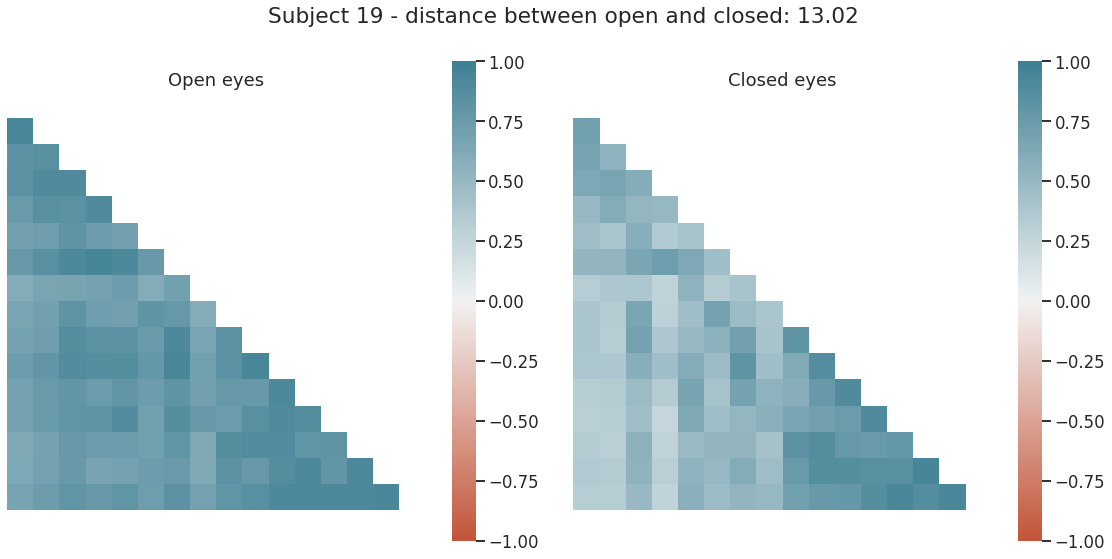

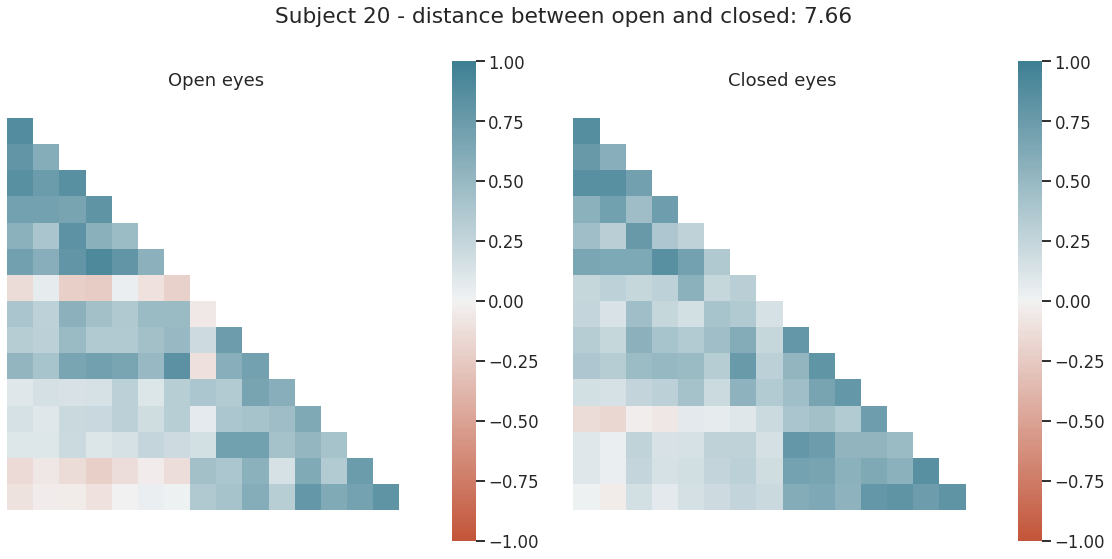

In [13]:
for i in np.arange(0, 40, 2):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
    sns.heatmap(data=corr_from_cov(Sigmas[i]),
                ax=ax[0],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=corr_from_cov(Sigmas[i+1]),
                ax=ax[1],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    ax[0].set_title('Open eyes')
    ax[1].set_title('Closed eyes')
    f.suptitle("Subject {:02} - distance between open and closed: {:.2f}".format(int(i/2 + 1), dist_riem_squared(Sigmas[i], Sigmas[i+1])))
    plt.tight_layout()
    plt.show()

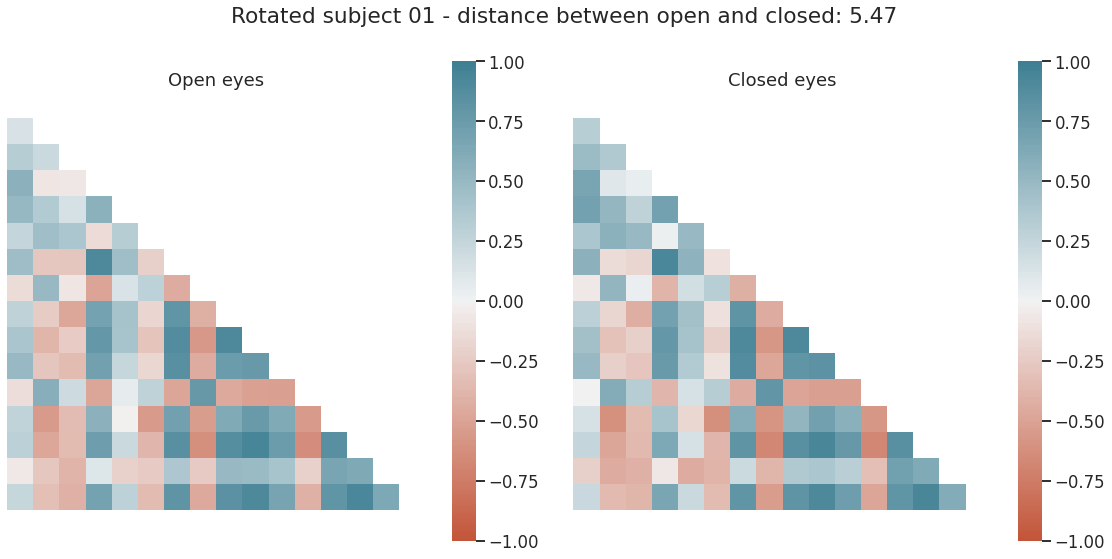

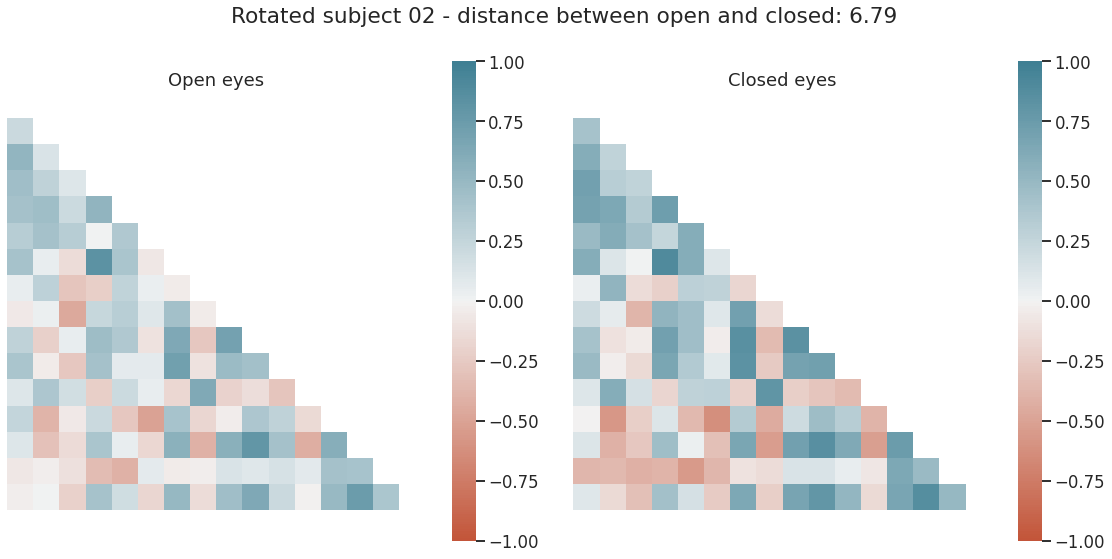

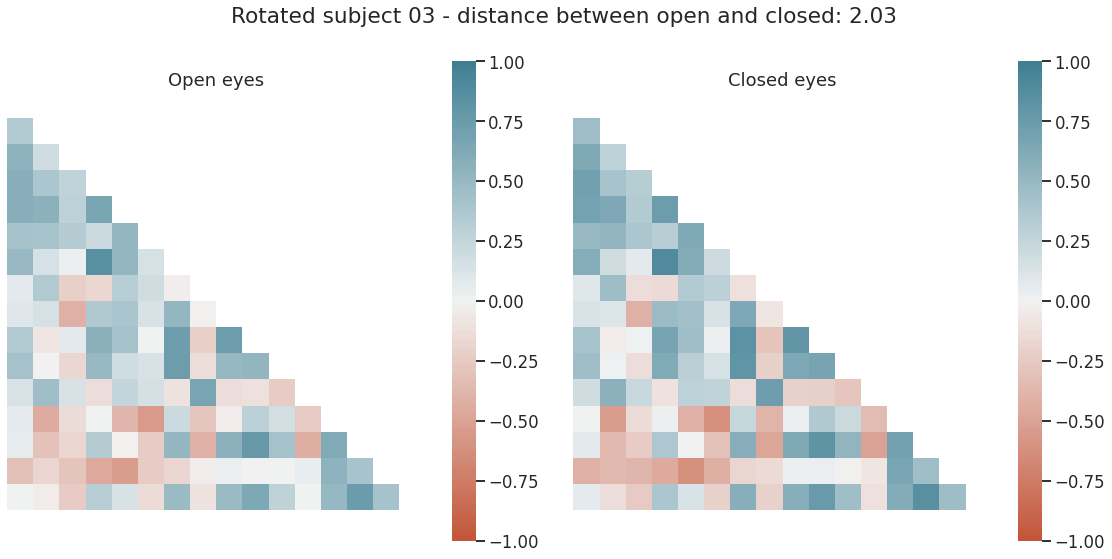

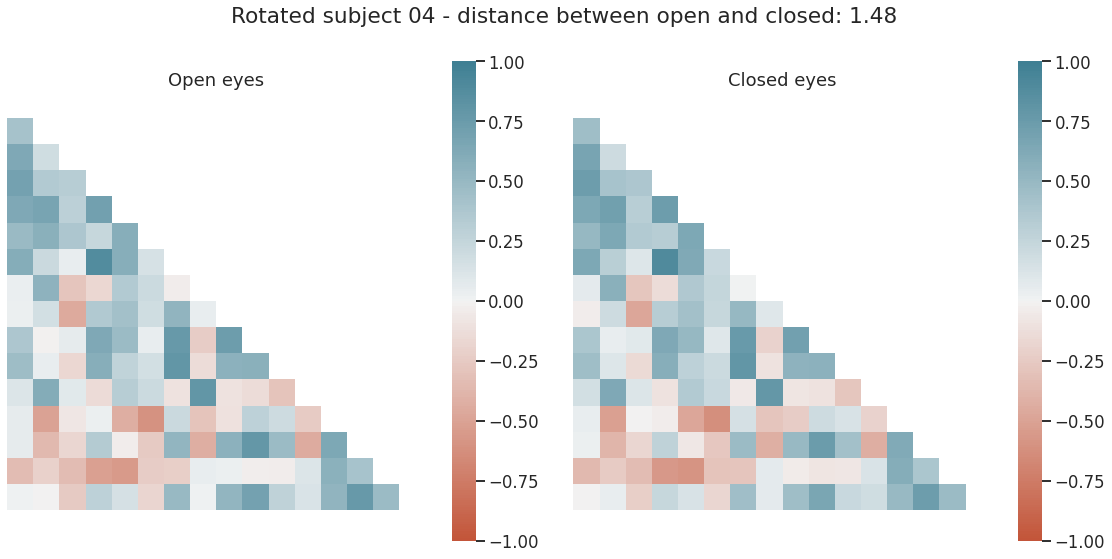

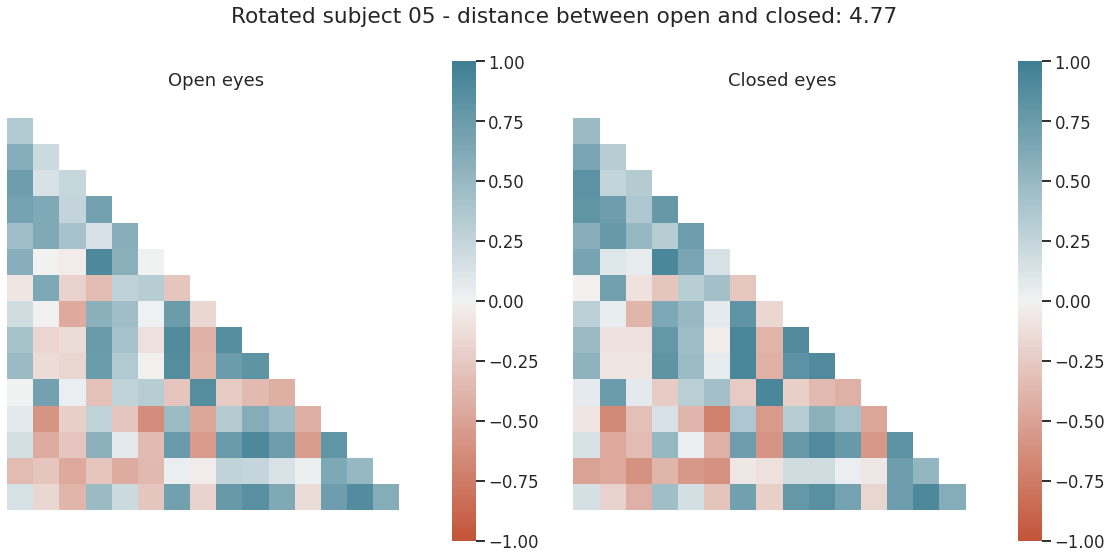

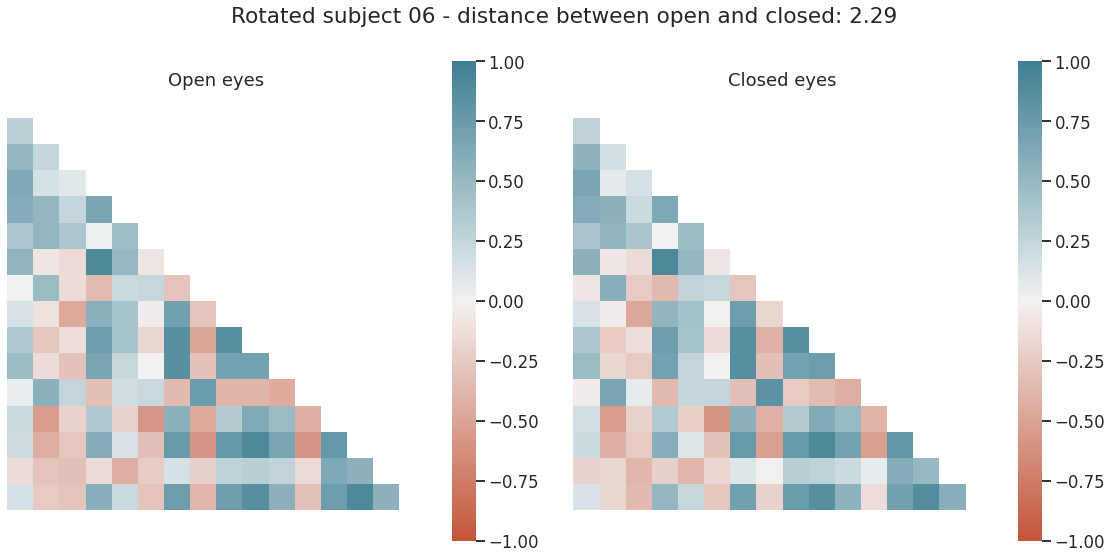

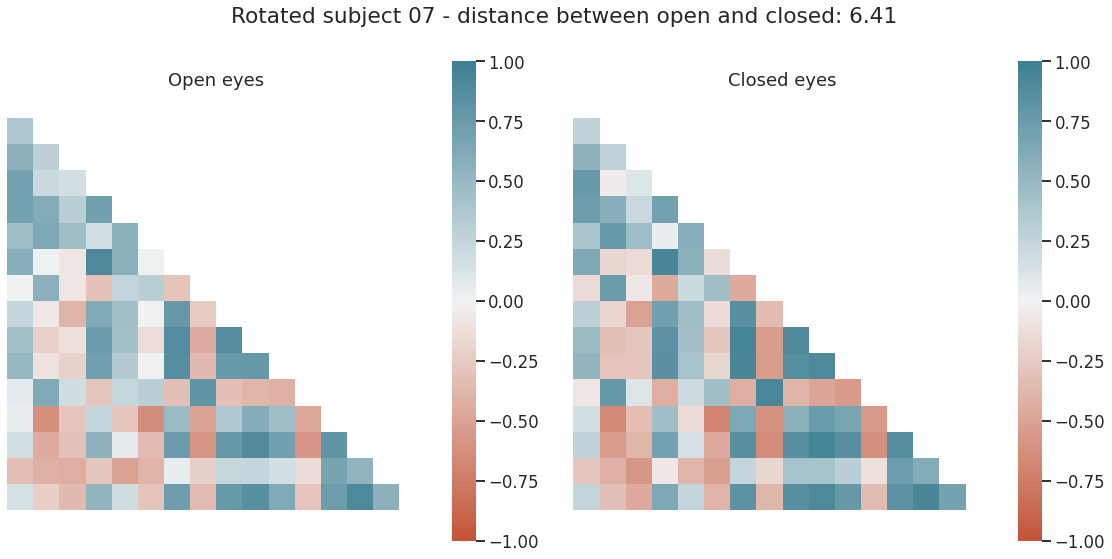

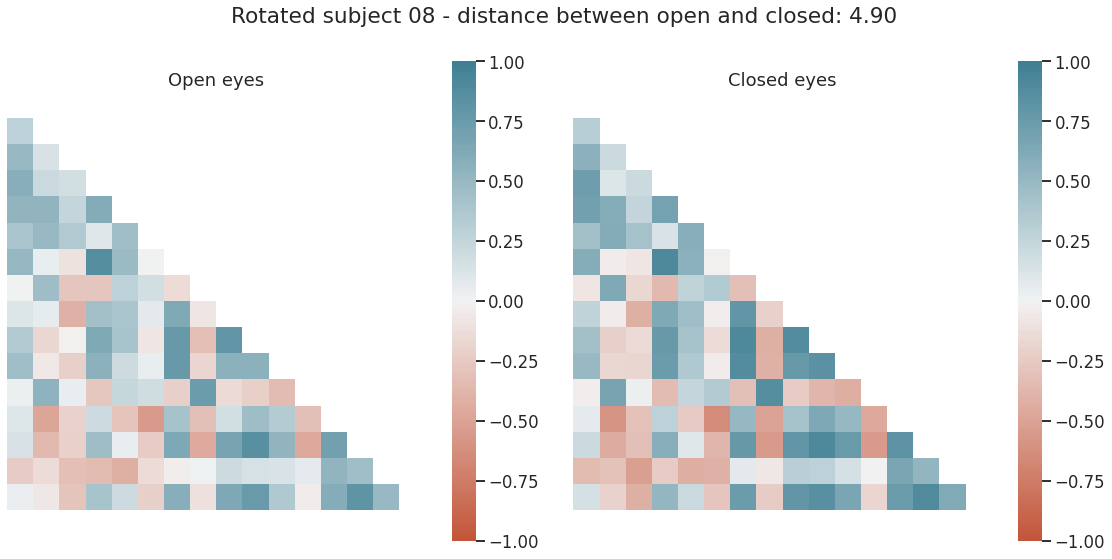

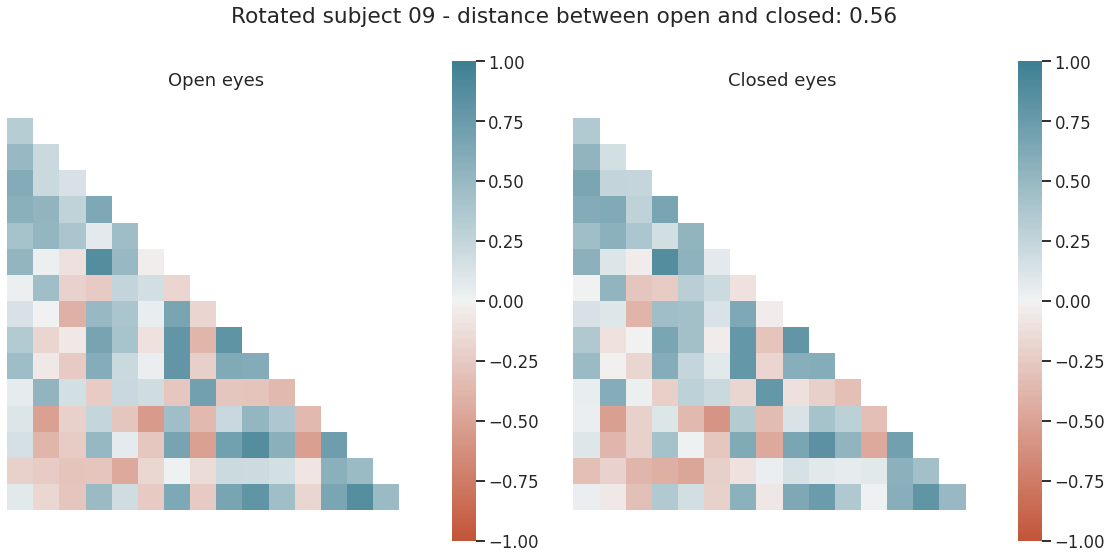

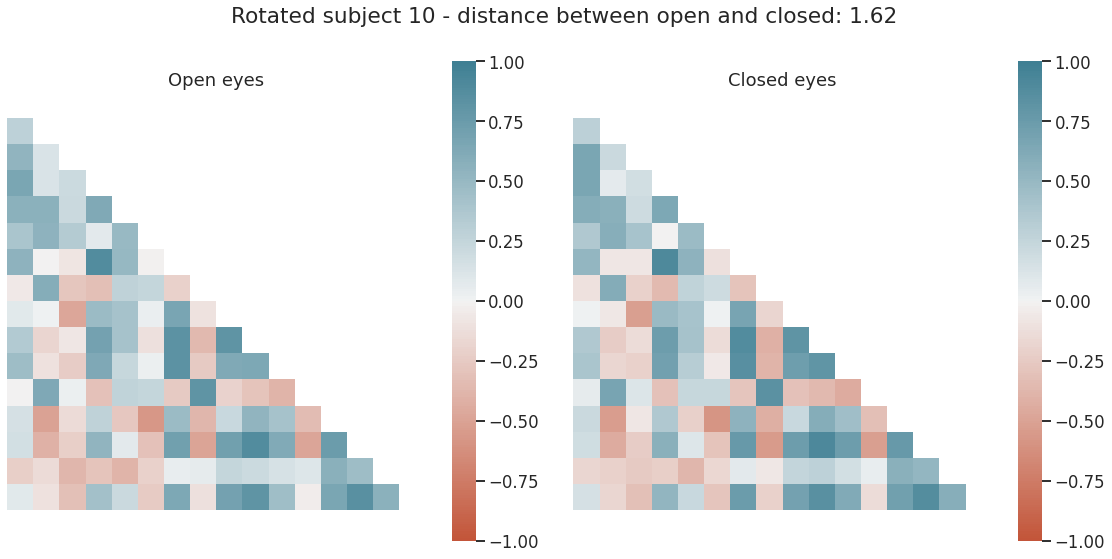

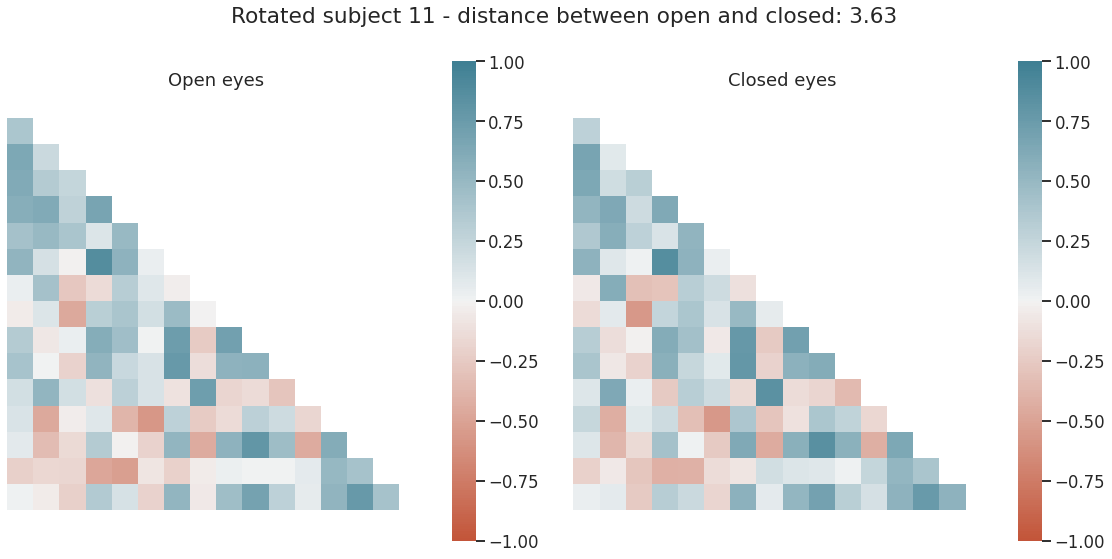

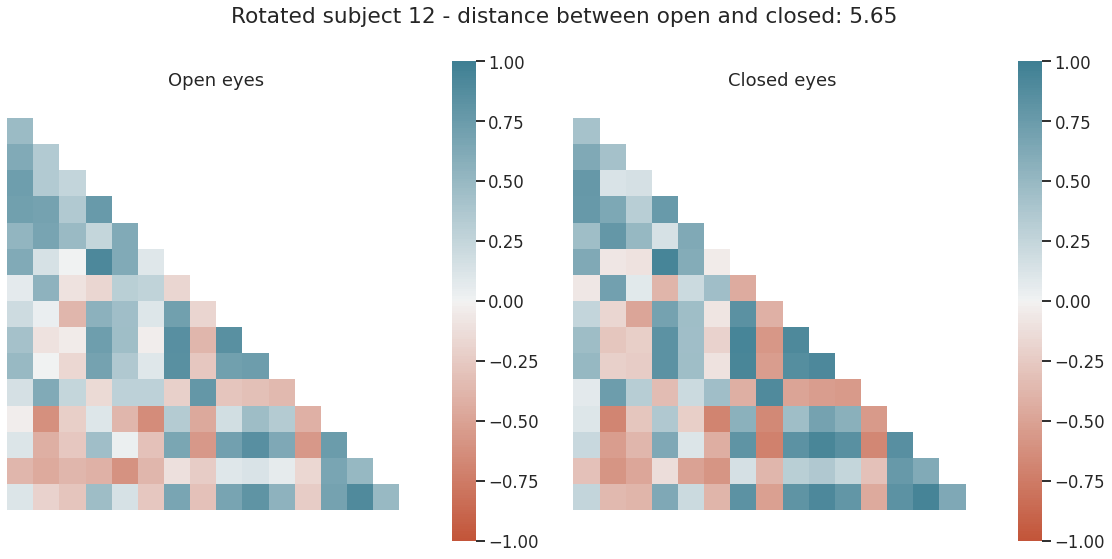

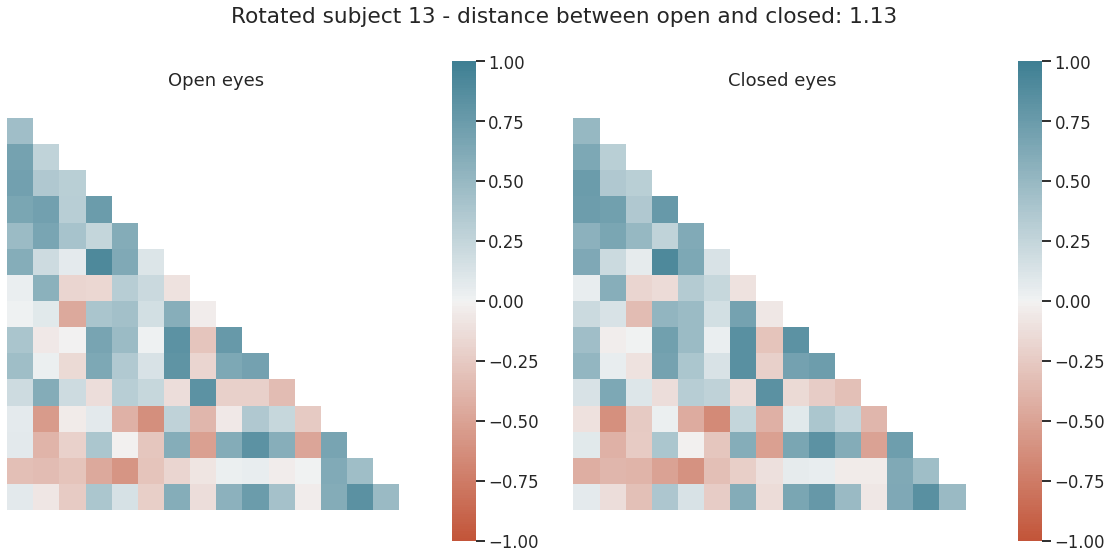

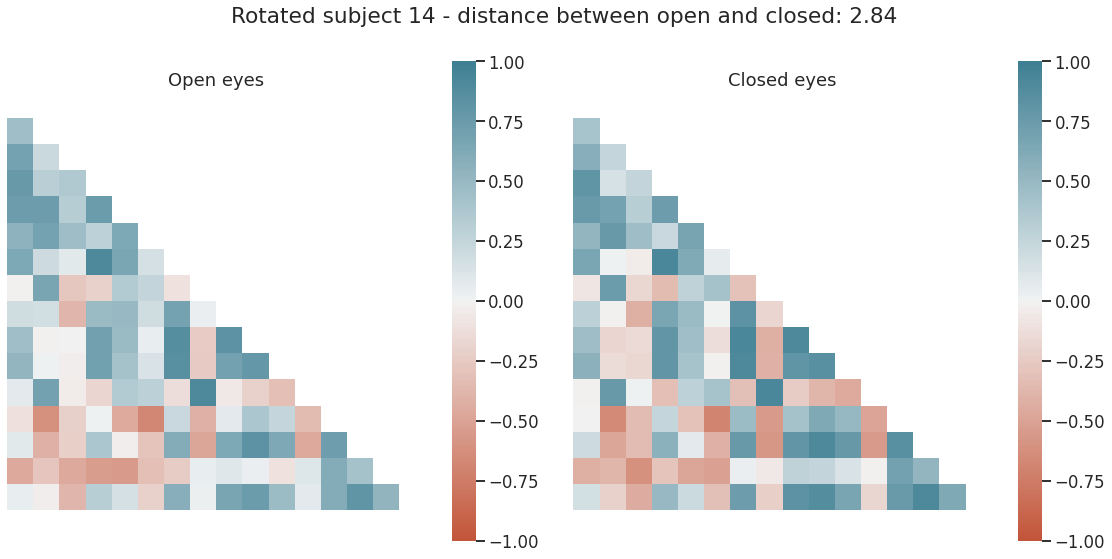

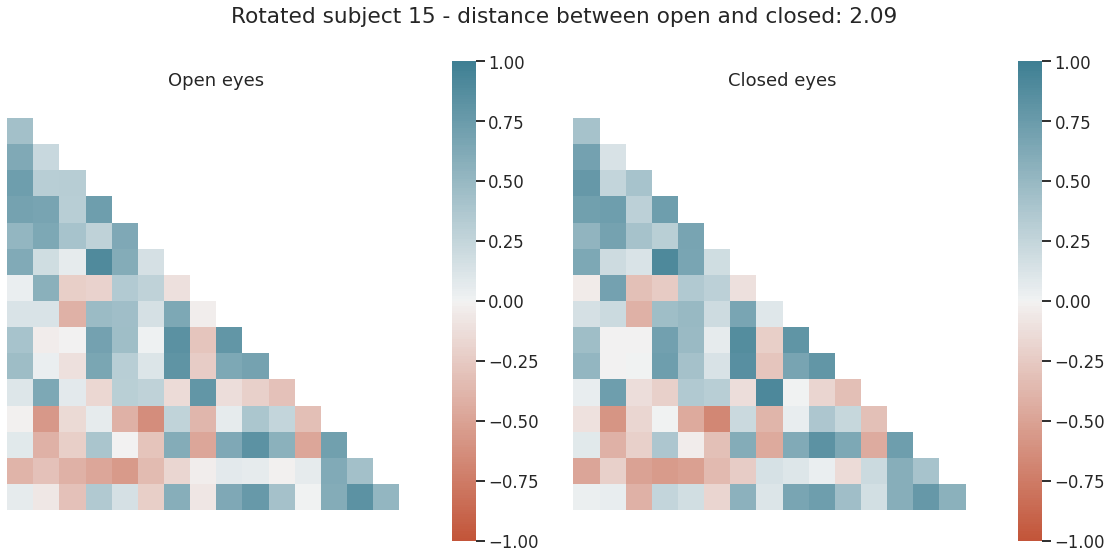

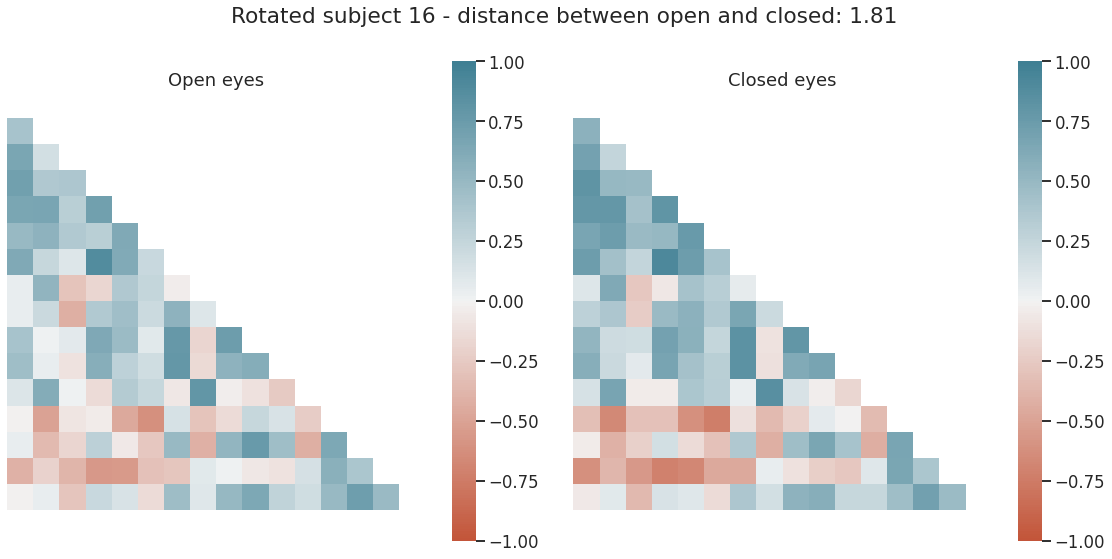

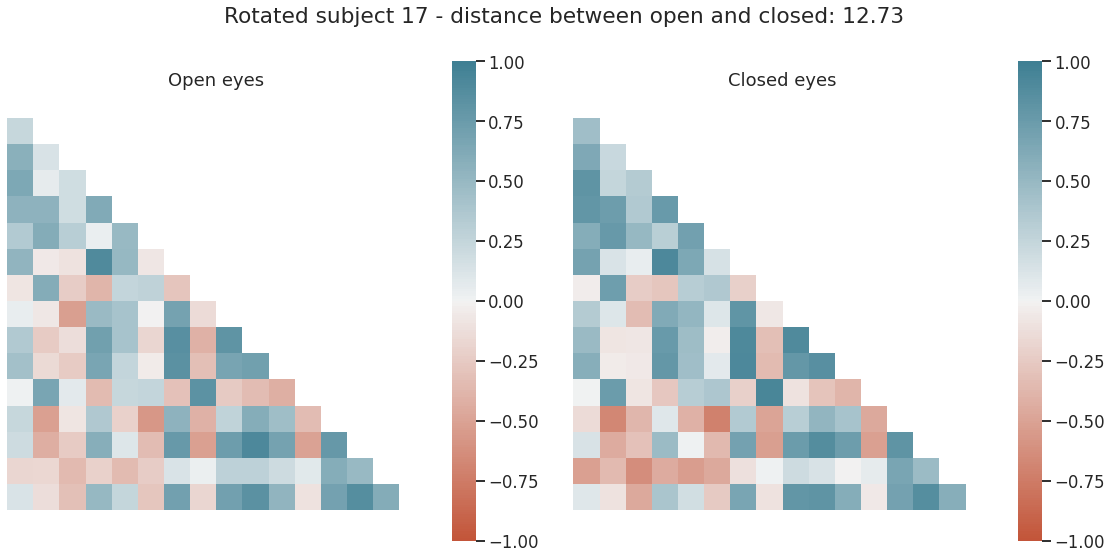

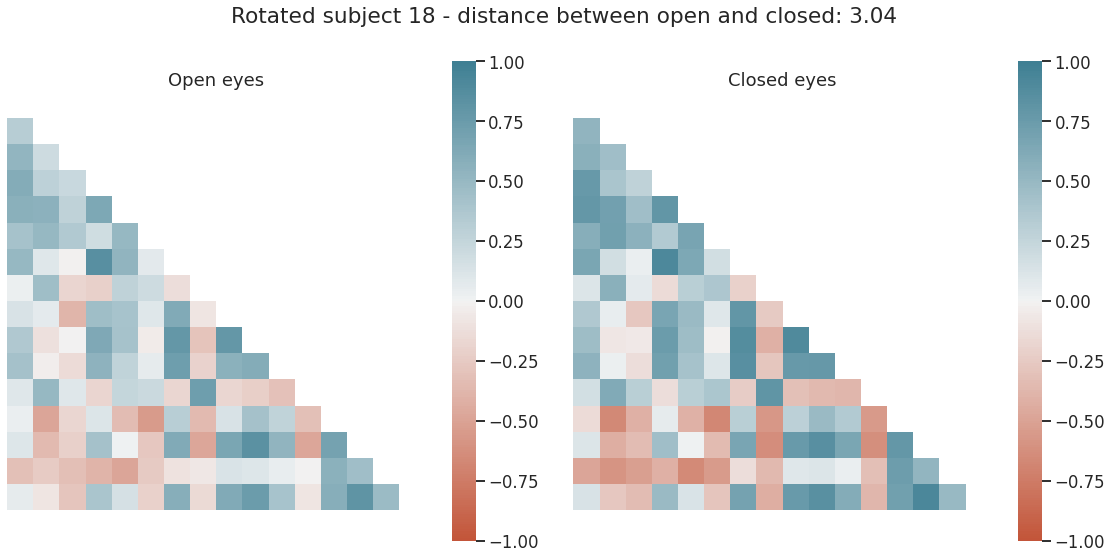

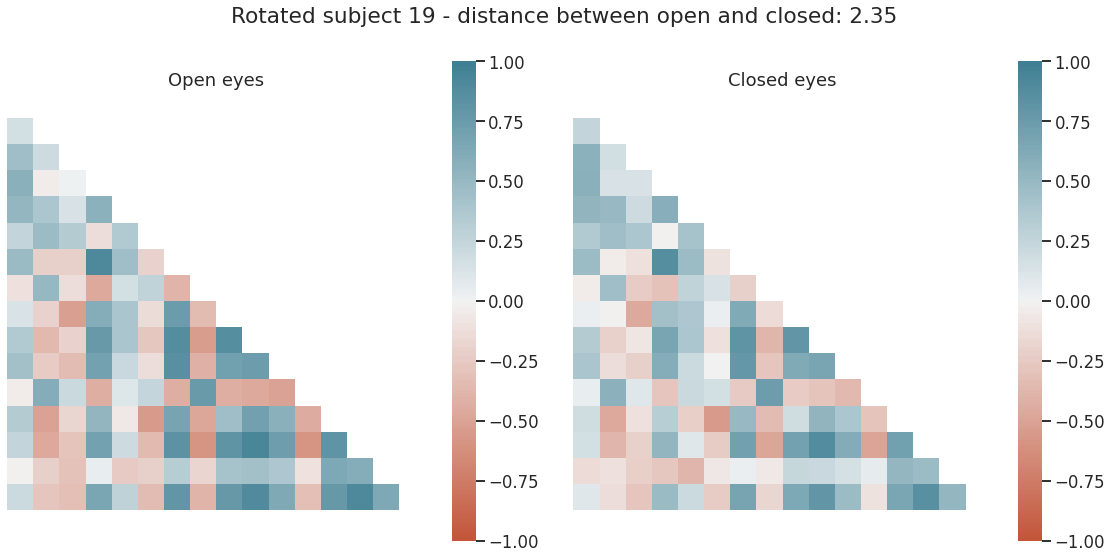

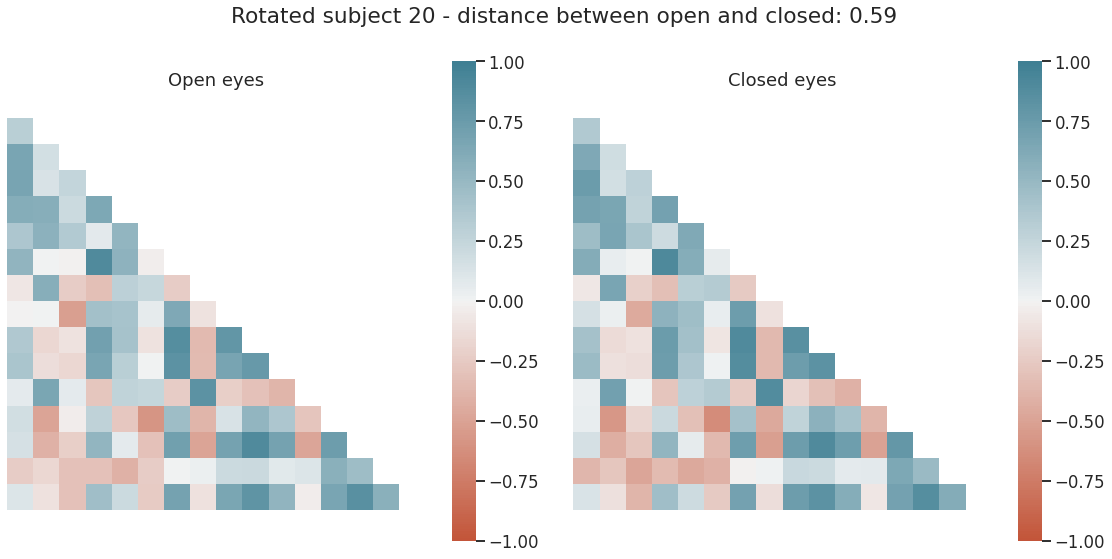

In [14]:
for i in np.arange(0, 40, 2):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
    sns.heatmap(data=corr_from_cov(Sigmas_rotated[i]),
                ax=ax[0],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=corr_from_cov(Sigmas_rotated[i+1]),
                ax=ax[1],
                vmin=s_min,
                vmax=s_max,
                cmap=colmap,
                mask=mask,
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    ax[0].set_title('Open eyes')
    ax[1].set_title('Closed eyes')
    f.suptitle("Rotated subject {:02} - distance between open and closed: {:.2f}".format(int(i/2 + 1), dist_riem_squared(Sigmas_rotated[i], Sigmas_rotated[i+1])))
    plt.tight_layout()
    plt.show()


In [15]:
from jax import jit, grad
from optispd.manifold import SPD
from optispd.minimizer import minimizer

def karcher(sigmas):
    cost = jit(lambda x: jnp.sum(dist_riem_squared(x, jnp.array(sigmas))))
    gr = jit(grad(cost))
    init = jnp.mean(sigmas, axis=0)
    
    man = SPD(16)
    opti = minimizer(man, 'rcg', verbosity=1, maxiter=100)
    res = opti.solve(cost, gr, x=init)
    print(res)
    return np.array(res.x)
    
print('\t...Barycenter of not rotated')
ori_bar = karcher(Sigmas)
#ori_bar_close = karcher(Sigmas[Number_of_Subjects:])
#ori_bar_open = karcher(Sigmas[:Number_of_Subjects])
print('\n\t... Barycenter of rotated')
rot_bar = karcher(Sigmas_rotated)
#rot_bar_close = karcher(Sigmas_rotated[Number_of_Subjects:])
#rot_bar_open = karcher(Sigmas_rotated[:Number_of_Subjects])


	...Barycenter of not rotated
Starting Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices
iteration: 17	fun value: 2629.02	[0.128 s]
Optimization not completed (status 5).	17 iterations in 4.487 s
Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices.
---
Success: False with status 5 in 4.487 s.
[status meaning: 0=converged, 1=stepsize too small, 2=max iters reached, 3=max time reached, 4=max cost evaluations, 5=function value not changing-1=undefined]
 -Iterations 17 (cost evaluation: 128, gradient evaluation: 128, time/it: 0.26392626762390137)
 	 Function value 2629.025, gradient norm 0.020081366771885708, stepsize 0.00015388616395734794,
 	 value of X:
	... Too big to show...

	... Barycenter of rotated
Starting Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices
iteration: 4	fun value: 438.29	[0.690 s]
Optimization not completed (status 5).	4 iterations in 3.382 s
Riemannian Conjugate Gradient 

In [16]:
S = jnp.array(Sigmas)
S2 = jnp.array(Sigmas_rotated)

d1 = dist_riem_squared(ori_bar, S)
d2 = dist_riem_squared(rot_bar, S2)

df = pd.DataFrame({'Not rotated': d1, 'Rotated': d2, 'Eyes':labels, 'Ages':ages, 'Subject':subjects, 'Gender':genders})
df = pd.melt(df, 
             id_vars=['Eyes', 'Ages', 'Subject', 'Gender'],
             var_name="Kind",
             value_name="Distance from reference"
            )

def age_groups(x):
    if x <= 20:
        return '<= 20'
    elif x <= 25:
        return '20 < x <= 25'
    elif x <= 28:
        return '25 < x <= 28'
    else:
        return '> 28'

df['Age group'] = df.Ages.apply(lambda x: age_groups(x))

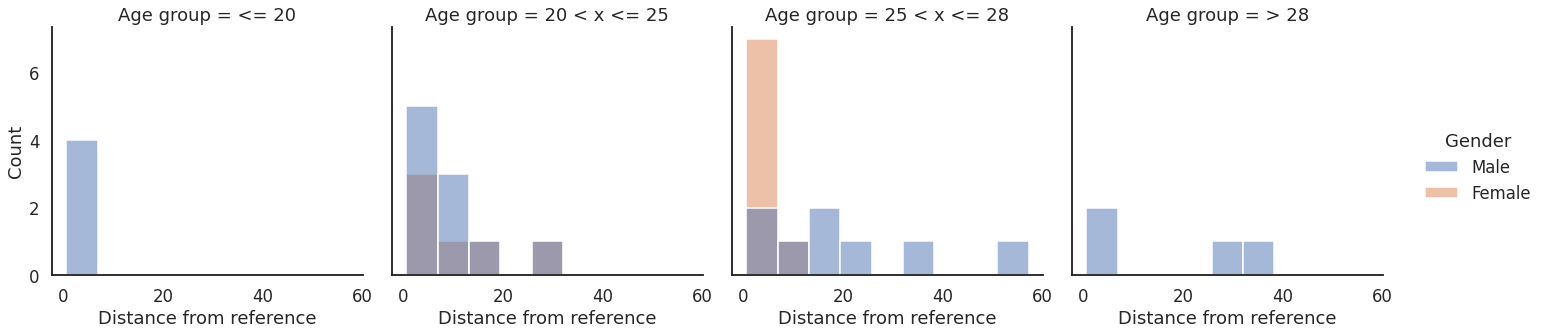

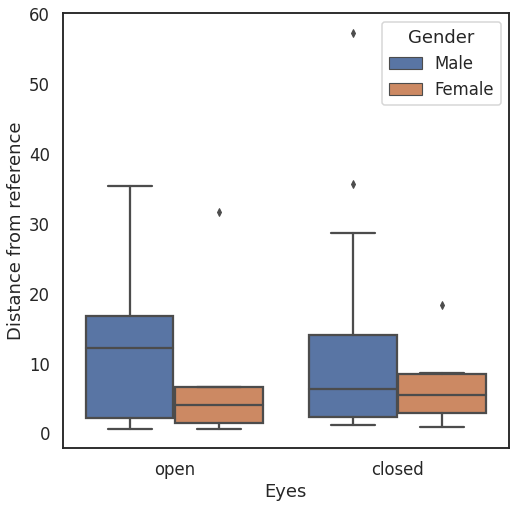

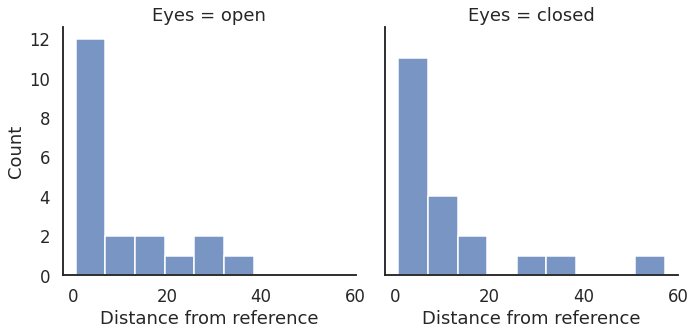

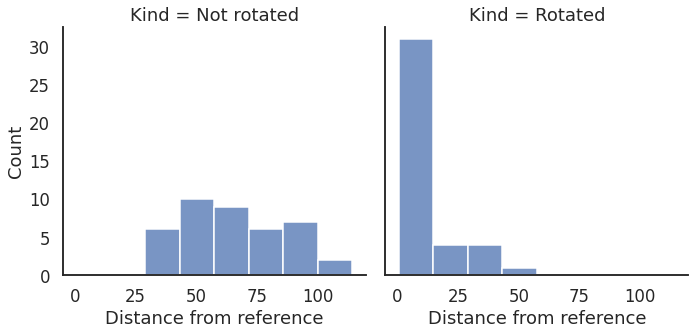

In [17]:
#f = plt.figure(figsize=(14,8))
sns.displot(data=df[df['Kind']=='Rotated'], 
            x='Distance from reference', 
            col='Age group', 
            hue='Gender',
            col_order=['<= 20', '20 < x <= 25', '25 < x <= 28', '> 28'],
           )
plt.show()

sns.boxplot(data=df[df['Kind']=='Rotated'],
            x='Eyes', 
            y='Distance from reference', 
            hue='Gender'
           )
plt.show()

sns.displot(data=df[df['Kind']=='Rotated'], 
            x='Distance from reference',
            col='Eyes',
            #hue='Gender',
            multiple='stack'
           )
plt.show()

sns.displot(data=df, 
            x='Distance from reference',
            col='Kind',
            multiple='stack'
           )
plt.show()

In [17]:
#df[(df['Kind'] == 'Rotated') & (df['Distance from reference'] > 20)]
# [s11, s3, s13, s7]
#df[(df['Kind'] == 'Not rotated') & (df['Distance from reference'] > 40)].sort_values('Distance from reference')

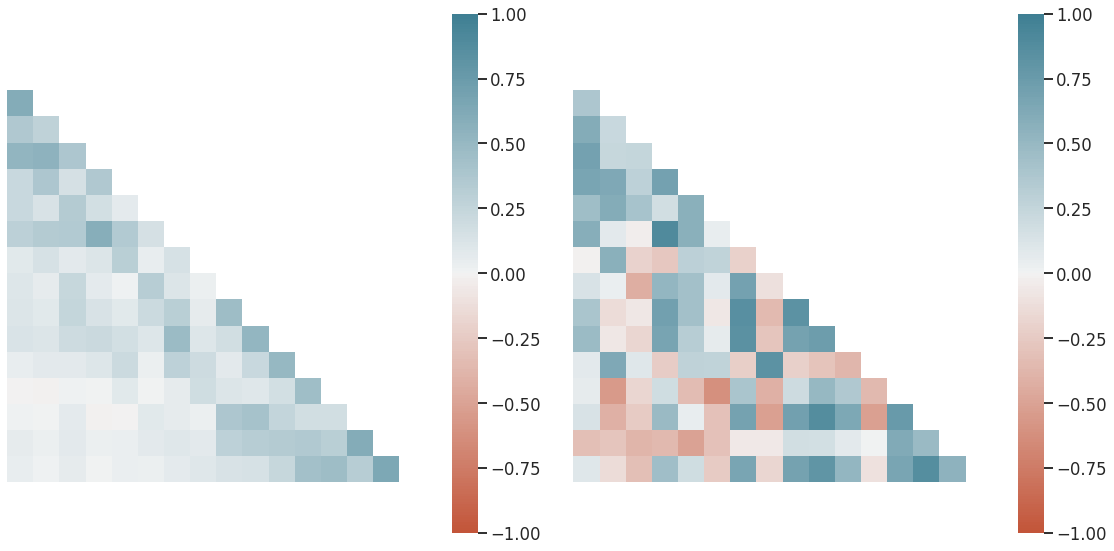

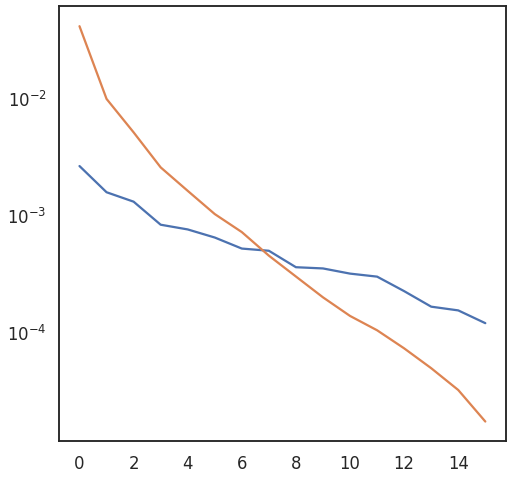

In [18]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))
sns.heatmap(data=corr_from_cov(ori_bar), 
            ax=ax[0],
            vmin=s_min,
            vmax=s_max,
            cmap=colmap,
            mask=mask,
            square=True,
            yticklabels=False,
            xticklabels=False
           )

sns.heatmap(data=corr_from_cov(rot_bar),
            ax=ax[1],
            vmin=s_min,
            vmax=s_max,
            cmap=colmap,
            mask=mask,
            square=True,
            yticklabels=False,
            xticklabels=False
           )
f.set_tight_layout(tight=True)
plt.show()
# print(dist_riem_squared(rot_bar, ori_bar))

plt.plot(range(16), np.linalg.eigvalsh(ori_bar)[::-1])
plt.plot(range(16), np.linalg.eigvalsh(rot_bar)[::-1])
plt.yscale('log')
plt.show()

In [19]:
chnames = ['Fp1',
           'Fp2',
           'FC5',
           'Fz',
           'FC6',
           'T7',
           'Cz',
           'T8',
           'P7',
           'P3',
           'Pz',
           'P4',
           'P8',
           'O1',
           'Oz',
           'O2'
          ]
chtypes = ['eeg'] * len(chnames)
info = mne.create_info(ch_names=chnames, sfreq=512, ch_types=chtypes, verbose=False)
info.set_montage('standard_1020')
nfree = np.mean(lengths)

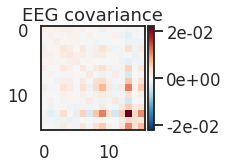

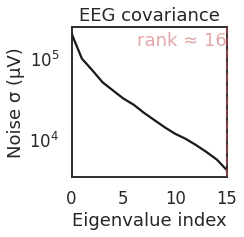

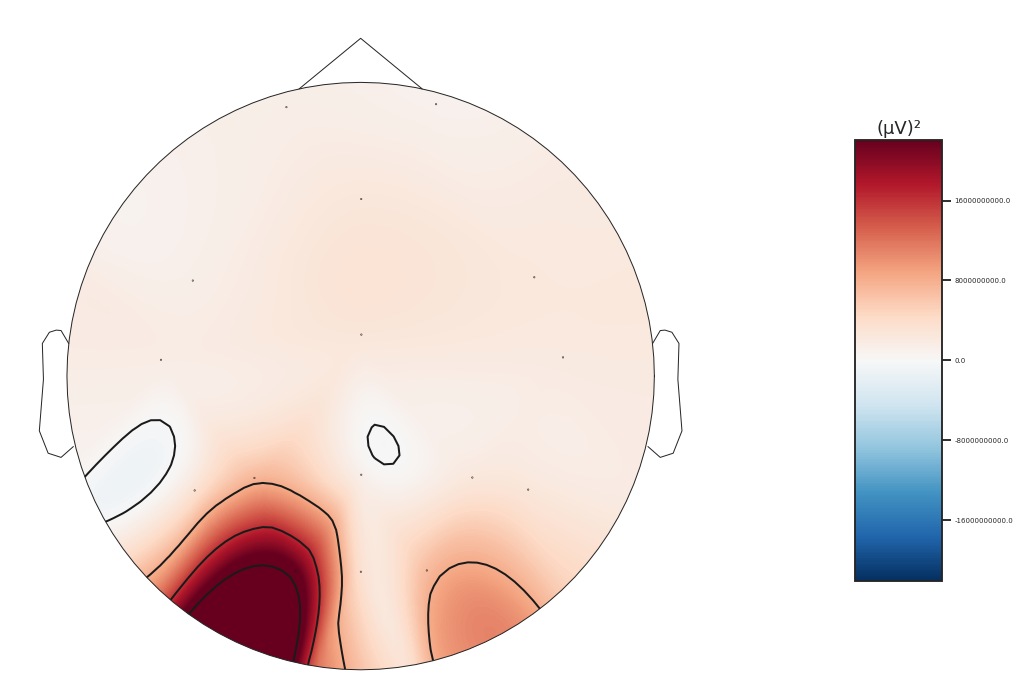

In [20]:
cov_rot = mne.Covariance(rot_bar, chnames, bads=[], projs=[], nfree=nfree, verbose=False)
cov_rot.plot(info)
cov_rot.plot_topomap(info, size=8)
plt.show()

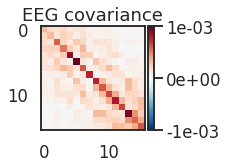

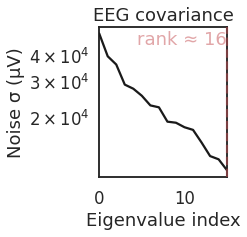

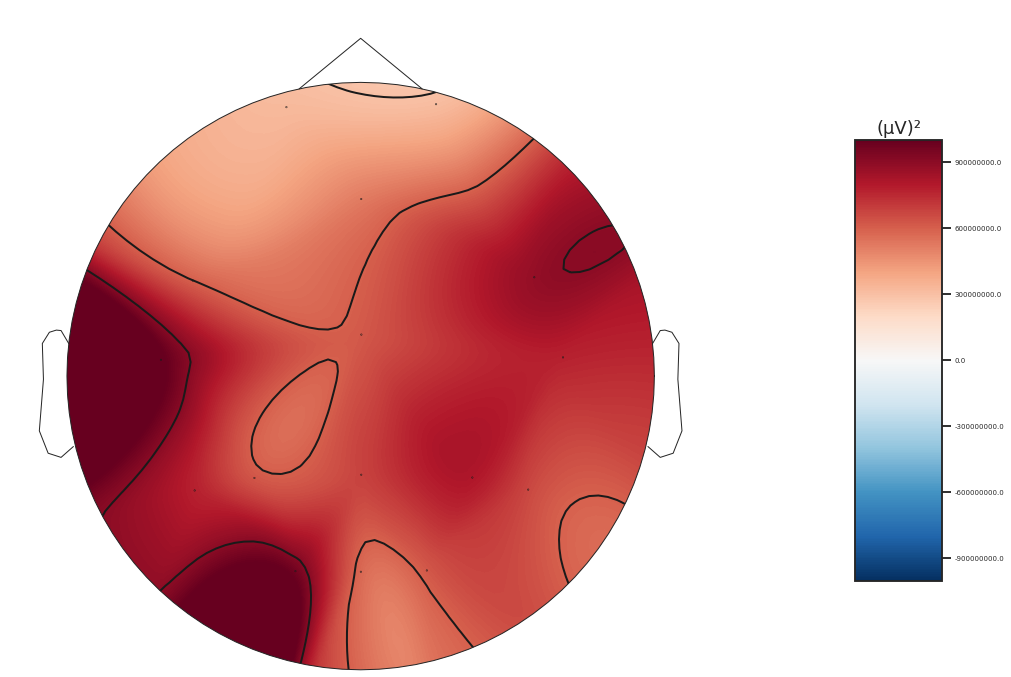

In [21]:
cov_ori = mne.Covariance(ori_bar, chnames, bads=[], projs=[], nfree=nfree, verbose=False)
cov_ori.plot(info)
cov_ori.plot_topomap(info, size=8)
plt.show()

# Classify open and closed eyes

In [22]:
Sigma_open = jnp.array([Sigmas[i] for i in jnp.arange(0, 40, 2)])
Sigma_closed = jnp.array([Sigmas[i+1] for i in jnp.arange(0, 40, 2)])

ref_eigvals_op = optimal_reference_eigval(Sigma_open)
ref_eigvect_op = optimal_reference_eigvec(Sigma_open)
reference_op = np.einsum('...ij,...j,...kj', ref_eigvect_op, ref_eigvals_op, ref_eigvect_op)

Omega_op = optimal_rotation(Sigma_open, reference_op)
Sigma_open_rot = rotate(Sigma_open, Omega_op)

ref_eigvals_cl = optimal_reference_eigval(Sigma_closed)
ref_eigvect_cl = optimal_reference_eigvec(Sigma_closed)
reference_cl = np.einsum('...ij,...j,...kj', ref_eigvect_cl, ref_eigvals_cl, ref_eigvect_cl)

Omega_cl = optimal_rotation(Sigma_closed, reference_cl)
Sigma_closed_rot = rotate(Sigma_closed, Omega_cl)


In [23]:
ori_bar_op = karcher(Sigma_open)
ori_bar_cl = karcher(Sigma_closed)

rot_bar_op = karcher(Sigma_open_rot)
rot_bar_cl = karcher(Sigma_closed_rot)


Starting Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices
iteration: 14	fun value: 1191.01	[0.113 s]
Optimization not completed (status 5).	14 iterations in 3.147 s
Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices.
---
Success: False with status 5 in 3.147 s.
[status meaning: 0=converged, 1=stepsize too small, 2=max iters reached, 3=max time reached, 4=max cost evaluations, 5=function value not changing-1=undefined]
 -Iterations 14 (cost evaluation: 100, gradient evaluation: 100, time/it: 0.22480324336460658)
 	 Function value 1191.011, gradient norm 0.010599619449790277, stepsize 0.00011810517498344505,
 	 value of X:
	... Too big to show...
Starting Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices
iteration: 14	fun value: 1410.46	[0.100 s]
Optimization not completed (status 5).	14 iterations in 3.181 s
Riemannian Conjugate Gradient on manifold of (16 x 16) positive definite matrices.
--

In [31]:
x_ori = np.append(dist_riem_squared(Sigma_open, ori_bar_op), dist_riem_squared(Sigma_closed, ori_bar_op))
y_ori = np.append(dist_riem_squared(Sigma_open, ori_bar_cl), dist_riem_squared(Sigma_closed, ori_bar_cl))

x_rot = np.append(dist_riem_squared(Sigma_open_rot, rot_bar_op), dist_riem_squared(Sigma_closed_rot, rot_bar_op))
y_rot = np.append(dist_riem_squared(Sigma_open_rot, rot_bar_cl), dist_riem_squared(Sigma_closed_rot, rot_bar_cl))

df_ori = pd.DataFrame({'distance from open bary': x_ori,
                       'distance from closed bary':y_ori,
                       'label':['Open'] * 20 + ['Closed'] * 20})
df_rot = pd.DataFrame({'distance from open bary': x_rot,
                       'distance from closed bary':y_rot,
                       'label':['Open'] * 20 + ['Closed'] * 20})



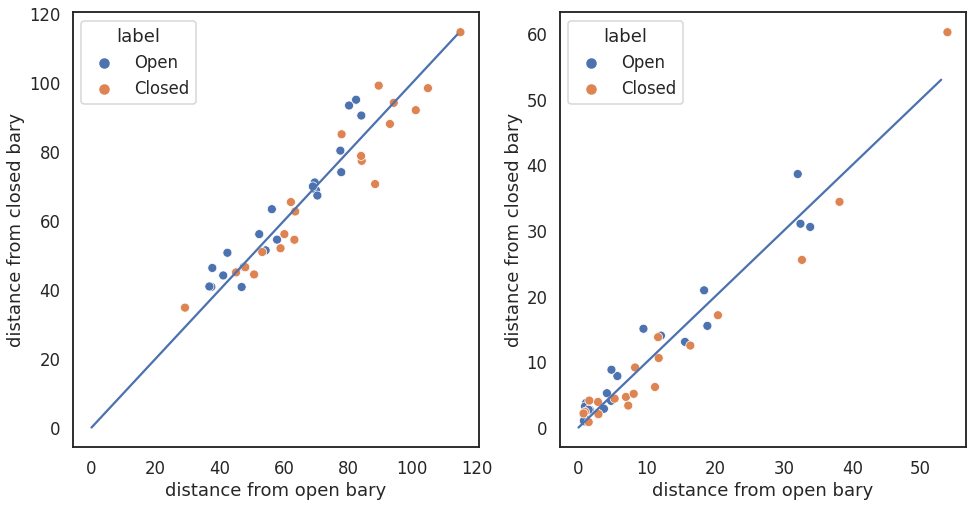

In [32]:
f, ax = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(data=df_ori, x='distance from open bary', y='distance from closed bary', hue='label', ax=ax[0])
ax[0].plot(np.arange(max(x_ori)), np.arange(max(x_ori)))
sns.scatterplot(data=df_rot, x='distance from open bary', y='distance from closed bary', hue='label', ax=ax[1])
ax[1].plot(np.arange(max(x_rot)), np.arange(max(x_rot)) )
plt.show();

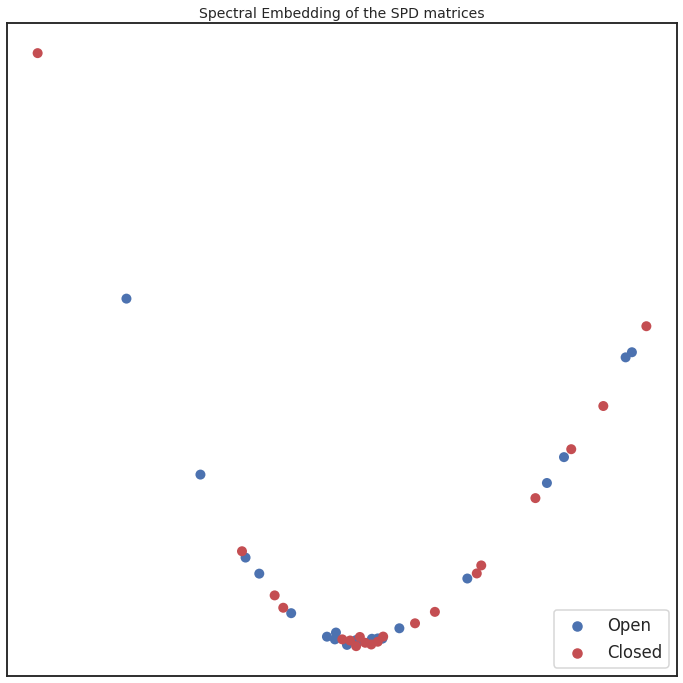

In [33]:
uorg, l = get_diffusionEmbedding(points=np.concatenate([Sigma_open_rot, Sigma_closed_rot], axis=0),
                                 distance=lambda x, y: np.sqrt(dist_riem_squared(x, y)))

# plot the scatter plot for the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(12,12))

colors = {'Open':'b', 'Closed':'r'}
for i in range(Sigmas_rotated.shape[0]):
    ax.scatter(uorg[i, 1], uorg[i, 2], s=100, facecolor=colors[df_rot['label'][i]], edgecolor='none')
ax.set_title('Spectral Embedding of the SPD matrices', fontsize=14)   
ax.set_xticks([])
ax.set_yticks([])
ax.scatter([], [], facecolor=colors['Open'], label='Open')
ax.scatter([], [], facecolor=colors['Closed'], label='Closed')
ax.legend(loc='lower right');

```
print("OPEN EYES")
f, ax = plt.subplots(Number_of_Subjects, 2, sharex=True, sharey=True, figsize=figsize)
for i in range(Number_of_Subjects):
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas[i])), 
                ax=ax[i, 0],
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[i])), 
                ax=ax[i, 1],
                vmin=s_max_ro,
                vmax=s_min_ro,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
ax[0,0].set_title('Original')
ax[0,1].set_title('Rotated')
#f.suptitle('Open eyes')
f.set_tight_layout(tight=True)
plt.show()
```

```
print("CLOSED EYES")
f, ax = plt.subplots(Number_of_Subjects, 2, sharex=True, sharey=True, figsize=figsize)
for i in range(Number_of_Subjects):
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas[Number_of_Subjects + i])), 
                ax=ax[i, 0],
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
    sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[Number_of_Subjects + i])), 
                ax=ax[i, 1],
                vmin=s_max_ro,
                vmax=s_min_ro,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
ax[0,0].set_title('Original')
ax[0,1].set_title('Rotated')
# f.suptitle('Closed eyes')
f.set_tight_layout(tight=True)
plt.show()
```

```
f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[1])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_1.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[1])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_1_rot.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[3])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_3.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[3])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_3_rot.pdf')
plt.show()


f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas[6])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_6.pdf')
plt.show()

f = plt.figure(figsize=(9, 9))
sns.heatmap(data=onp.array(corr_from_cov(Sigmas_rotated[6])), 
                vmin=s_max_or,
                vmax=s_min_or,
                cmap=colmap,
                mask=onp.array(mask),
                square=True,
                yticklabels=False,
                xticklabels=False
               )
f.set_tight_layout(tight=True)
plt.savefig('../plots/subject_6_rot.pdf')
plt.show()
```

```
print("CLOSED EYES")
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar_close)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar_close)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()
```

```
print("OPEN EYES")
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
sns.heatmap(data=onp.array(corr_from_cov(ori_bar_open)), 
            ax=ax[0],
            vmin=s_max_or,
            vmax=s_min_or,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
sns.heatmap(data=onp.array(corr_from_cov(rot_bar_open)), 
            ax=ax[1],
            vmin=s_max_ro,
            vmax=s_min_ro,
            cmap=colmap,
            mask=onp.array(mask),
            square=True,
            yticklabels=False,
            xticklabels=False
           )
ax[0].set_title('Original')
ax[1].set_title('Rotated')
f.set_tight_layout(tight=True)
plt.show()
```